In [1]:
import pandas as pd
import glob
import os 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from Bio import SeqIO
import tarfile
import gzip
%load_ext autoreload
%autoreload 2
from helpers_barplot_intersection import plot_intersection_bars, plotting_parameters



Matplotlib created a temporary config/cache directory at /scratch/slurm-job.4339123/matplotlib-4qbgfame because the default path (/cluster/customapps/biomed/grlab/users/prelotla/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
class MS_parameters():
    def __init__(self, FDR_limit):
        self.FDR_limit = FDR_limit
    def edit_pep_type(self, pep_type):
        self.pep_type = pep_type
    def edit_MS(self, MS_FDR, MS_strategy):
        self.MS_FDR = MS_FDR
        self.MS_strategy = MS_strategy
        
   

In [3]:
# INPUTS 
proteomicsdir = '/cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024'
#proteomicsdir = '/cluster/work/grlab/projects/projects2020_OHSU/proteomics'


FDR_limit = 0.05
MS_FDR_ = ['_crema', '_crux']
MS_strategy_ = ['joint', 'pool', 'single']

#pool: pool all experiments per pipeline
#joint: pool all experiments for both pipeline
#single: per experiment per pipeline


sample_plot_dir = {}
run_type_plot_dir = {}    
all_samples = []

# BRCA
samples = ['TCGA-C8-A12P-01A-11R-A115-07',
                  'TCGA-AO-A0JM-01A-21R-A056-07',
                  'TCGA-BH-A18V-01A-11R-A12D-07',
                  'TCGA-A2-A0D2-01A-21R-A034-07',
                  'TCGA-A2-A0SX-01A-12R-A084-07']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'BRCA'
    
# OV
samples = ['TCGA-25-1319-01A-01R-1565-13',
                  'TCGA-25-1313-01A-01R-1565-13',
                  'TCGA-61-2008-01A-02R-1568-13',
                  'TCGA-24-1431-01A-01R-1566-13',
                  'TCGA-24-2298-01A-01R-1569-13']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'OV'

save_folder = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots'

# PLOTTING Parameters 
ticks_fontsize = 12
axislabels_fontsize = 12
legend_fontsize = 12
axes_fontsize = 15
color1 = 'gold'
color2 = 'crimson'
color3 = 'mediumblue'
color4 = 'moccasin'
colorgrid = 'grey'



save = False
sample = None

# Initialize plotting parameters
param_object = plotting_parameters(ticks_fontsize, axislabels_fontsize, legend_fontsize, axes_fontsize)
param_object.add_saving_instructions(save, run_type_plot_dir, sample_plot_dir)
param_object.add_color_options(color1, color2, color3, color4, colorgrid)

param_MS = MS_parameters(FDR_limit)

# Plot: Results per experiment

In [4]:
def calculate_mean_std(df, group_cols, target_cols, run_type_plot_dir, sample, decimals=1):
    # Restrict table to cohort
    all_samples = [s for s in run_type_plot_dir 
                   if run_type_plot_dir[sample] == run_type_plot_dir[s]]
    df = df.set_index('sample').loc[all_samples].reset_index()
    
    
    # Compute means and std
    df_means = df.groupby(group_cols)[target_cols].mean().reset_index().rename({col : 'mean_' + col 
                                                                     for col in target_cols}, axis = 1)
    df_std = df.groupby(group_cols)[target_cols].std().reset_index().rename({col : 'std_' + col 
                                                                     for col in target_cols}, axis = 1)

    df = df.merge(df_means, on = group_cols).merge(df_std, on = group_cols)
    
    for col in df.columns:
        if ('mean_' in col):
            df[col] = [np.round(i, decimals) for i in df[col]]
            if decimals == 0:
                df[col] = [int(i) for i in df[col]]
    return df

In [5]:
# Wrapper for plotting function 
def run_sample_plotting_overlap(order_file, sample, df, param_MS, param_object):

    # Ordering
    order_file = pd.read_csv(order_file, sep = '\t')
    #display(order_file.head(3))
    df_plot = order_file.merge(df, on = ['sample', 'filter_'], how = 'inner')
    df_plot = df_plot.fillna(0)
    print(df_plot.shape)
    df_plot = df_plot.sort_values('index')
    #display(df_plot.head(3))
    

    # Plotting labels and ticks
    param_object.add_x_label('GTEX (reads, samples)', 
                             f'{param_object.run_type_plot_dir[sample].upper()} (min, reads, samples)')
    
    param_object.add_ticks(df_plot['filter_background'], df_plot['filter_foreground'] )
    
    
    param_object.add_plotting_data(data_eth=df_plot, 
                                   data_ohsu=df_plot, 
                                   data_both=df_plot, 
                                   serie_index='index', 
                                   serie_intersection='mean_pep_size_intersection',
                                   serie_eth='mean_pep_size_eth', 
                                   serie_ohsu='mean_pep_size_ohsu')
    
    param_object.add_y_label('Number of MS-detected tryptic junction-peptides')
    
    param_object.add_saving_path(param_object.sample_plot_dir[sample], sample,
                                 f'Barplot_overlap_{param_MS.pep_type}{param_MS.MS_FDR}_{param_MS.MS_strategy}')
    
    param_object.add_labels('Mean intersection size', 'Mean total set size Graph Pipeline',
                            'Mean set size Junction Pipeline')
    
    ms = param_MS.MS_FDR.replace('_', '')
    param_object.add_title(f'{param_MS.pep_type} searched with {ms} in {param_MS.MS_strategy} strategy \n')

    # Plotting function
    plot_intersection_bars(param_object)
    return df_plot

In [6]:
# Wrapper for plotting function 

def run_sample_plotting_rates(order_file, sample, df, param_MS, param_object ):
    
    # Ordering
    order_file = pd.read_csv(order_file, sep = '\t')
    #display(order_file.head(3))
    df_plot = order_file.merge(df, on = ['sample', 'filter_'], how = 'inner')
    df_plot = df_plot.fillna(0)
    print(df_plot.shape)
    df_plot = df_plot.sort_values('index')
    #display(df_plot.head(3))


    # Plotting labels and ticks
    param_object.add_x_label('GTEX (reads, samples)', 
                             f'{param_object.run_type_plot_dir[sample].upper()} (min, reads, samples)')

    back_ticks = df_plot.loc[df_plot['pipeline'] == 'ETH', 'filter_background'] 
    front_ticks = df_plot.loc[df_plot['pipeline'] == 'ETH', 'filter_foreground']
    param_object.add_ticks(back_ticks, front_ticks)
    

    param_object.add_plotting_data(data_both=None, 
                                   data_eth=df_plot.loc[df_plot['pipeline'] == 'ETH'],
                                   data_ohsu=df_plot.loc[df_plot['pipeline'] == 'OHSU'],
                                   serie_index=None,
                                   serie_intersection=None,
                                   serie_eth='mean_validation_rate',
                                   serie_ohsu='mean_validation_rate')
     
    param_object.add_y_label('Validation percent')

    param_object.add_saving_path(param_object.sample_plot_dir[sample], sample, 
                                 f'Barplot_val_rate_{param_MS.pep_type}{param_MS.MS_FDR}_{param_MS.MS_strategy}')
    
    param_object.add_labels(None, 'Graph Pipeline',
                            'Junction Pipeline')
    
    ms = param_MS.MS_FDR.replace('_', '')
    param_object.add_title(f'{param_MS.pep_type} searched with {ms} in {param_MS.MS_strategy} strategy \n')
    
    plot_intersection_bars(param_object)


    return df_plot

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crema_joint.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU              5.1
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU              5.1
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

(70, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_kmer_crema_joint.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


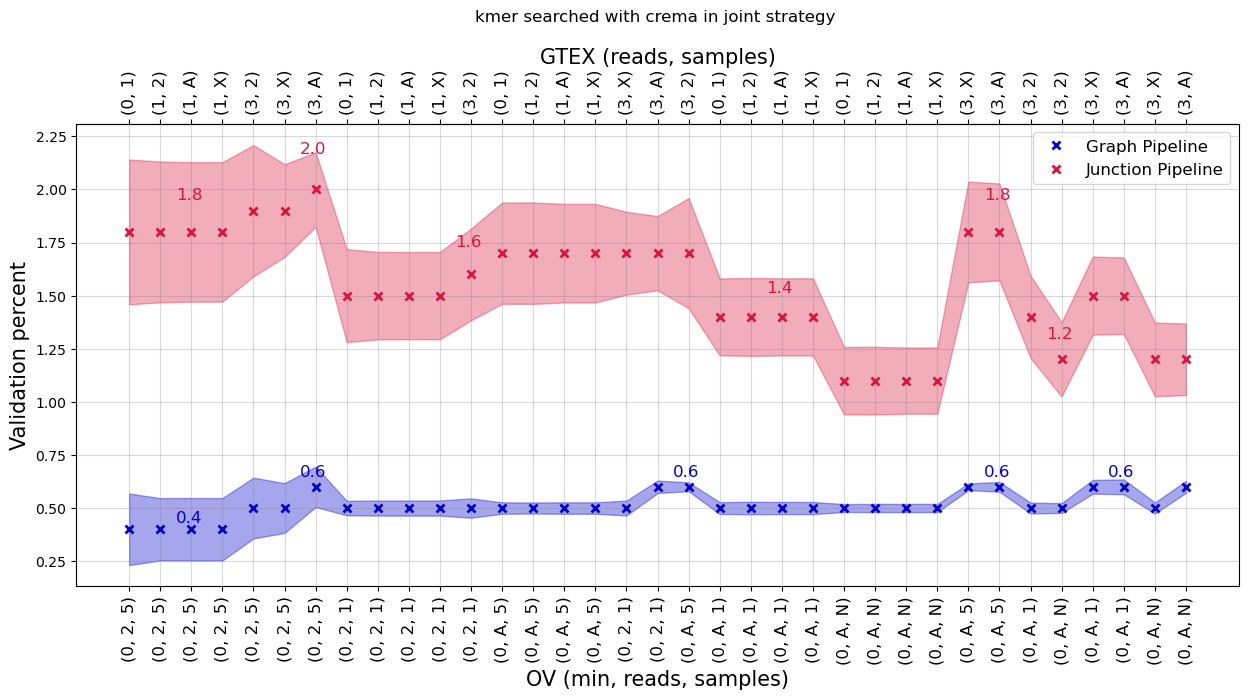

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crema_joint.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU             20.0
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU             20.0
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

(70, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_tryp-pep_crema_joint.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


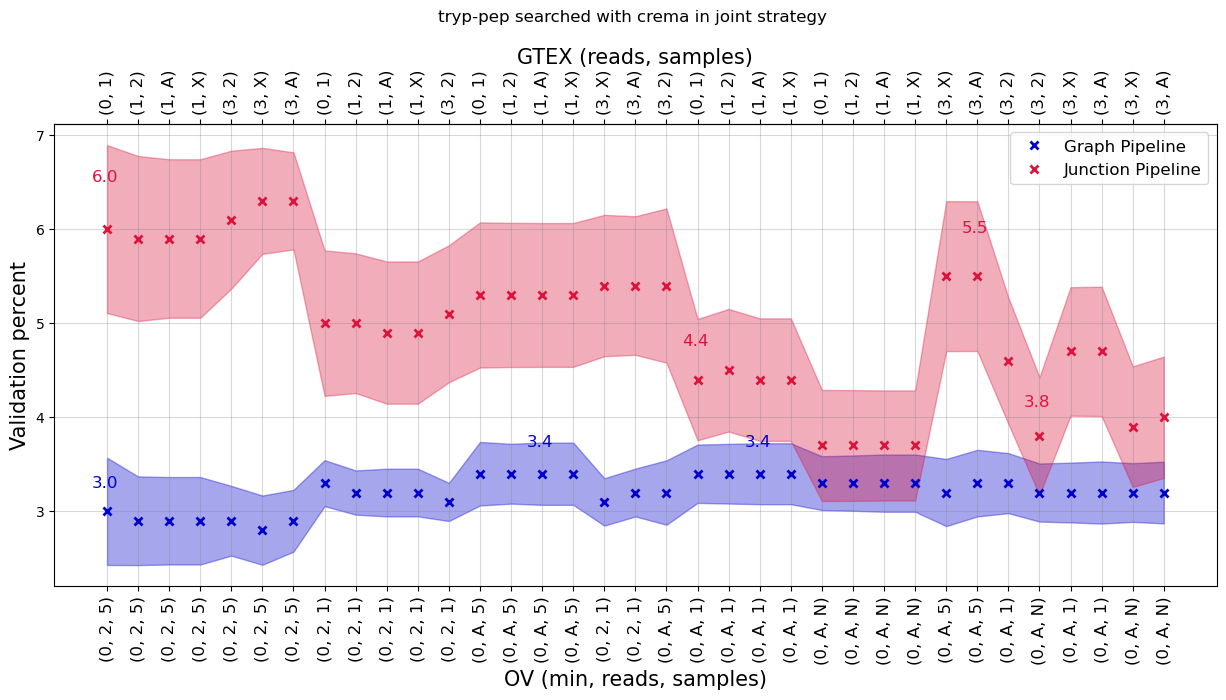

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crema_joint.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              8             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              8             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              8             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  8                  0  
1                      0                  8                  0  
2                      0                  0                  0  
3                      0                  8                  0  
4                      0                  0                  0

(35, 33)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_kmer_crema_joint.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


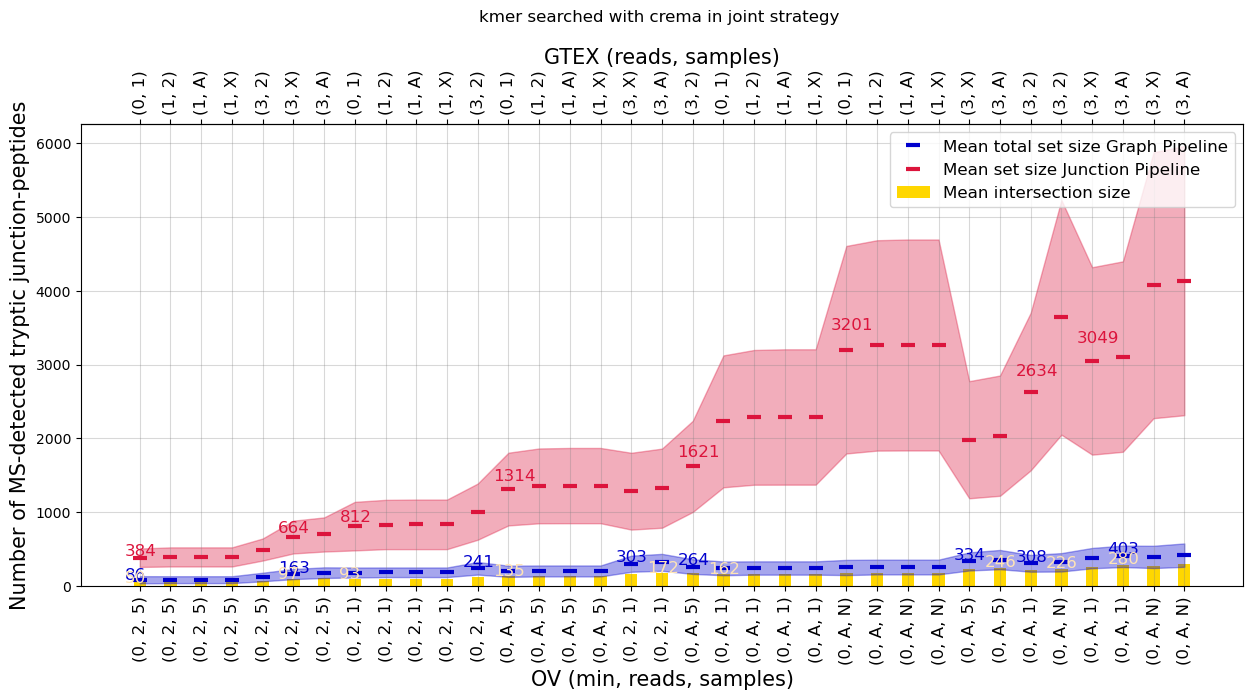

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crema_joint.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              1             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              1             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              1             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  1                  0  
1                      0                  1                  0  
2                      0                  0                  0  
3                      0                  1                  0  
4                      0                  0                  0

(35, 33)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_tryp-pep_crema_joint.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


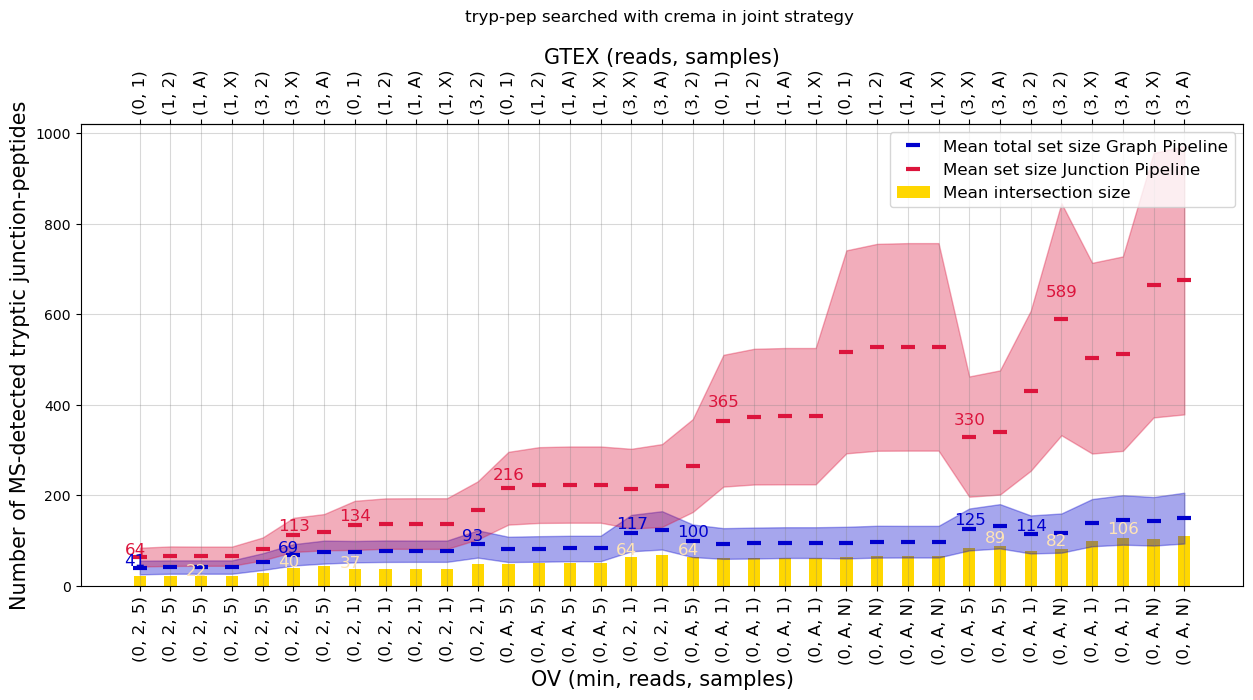

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crema_joint.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU              5.1
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU              5.1
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

(54, 21)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_kmer_crema_joint.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


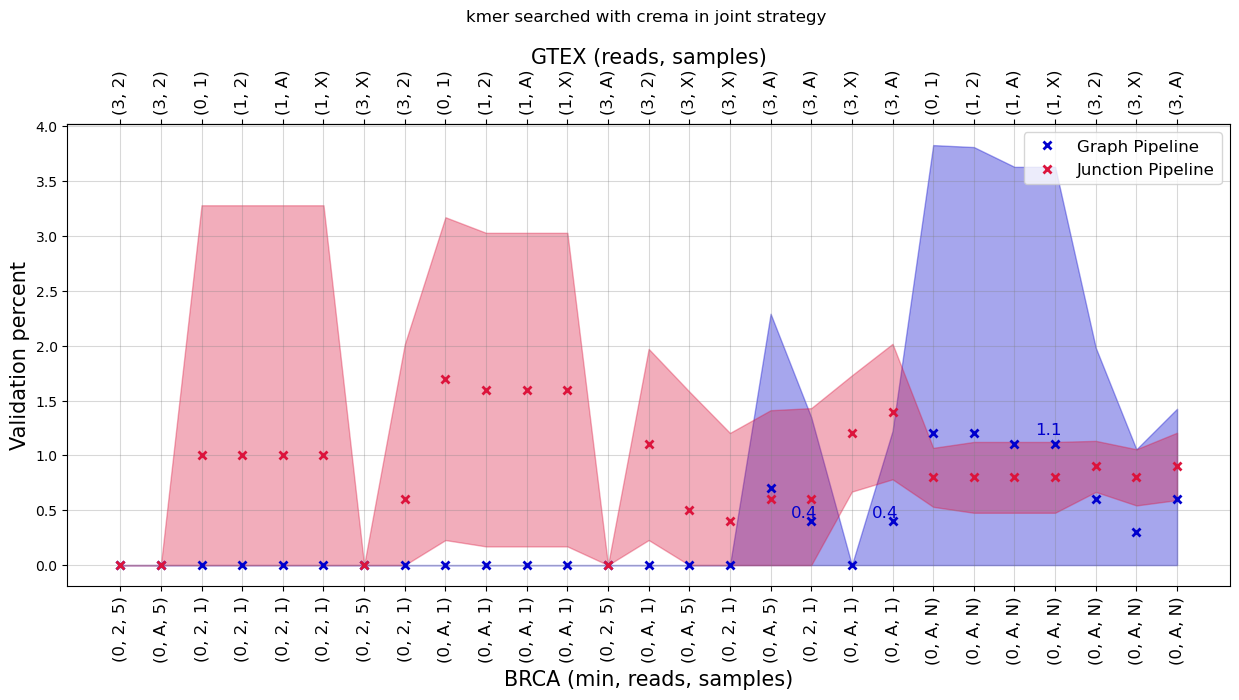

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crema_joint.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU             20.0
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU             20.0
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


(54, 21)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_tryp-pep_crema_joint.pdf


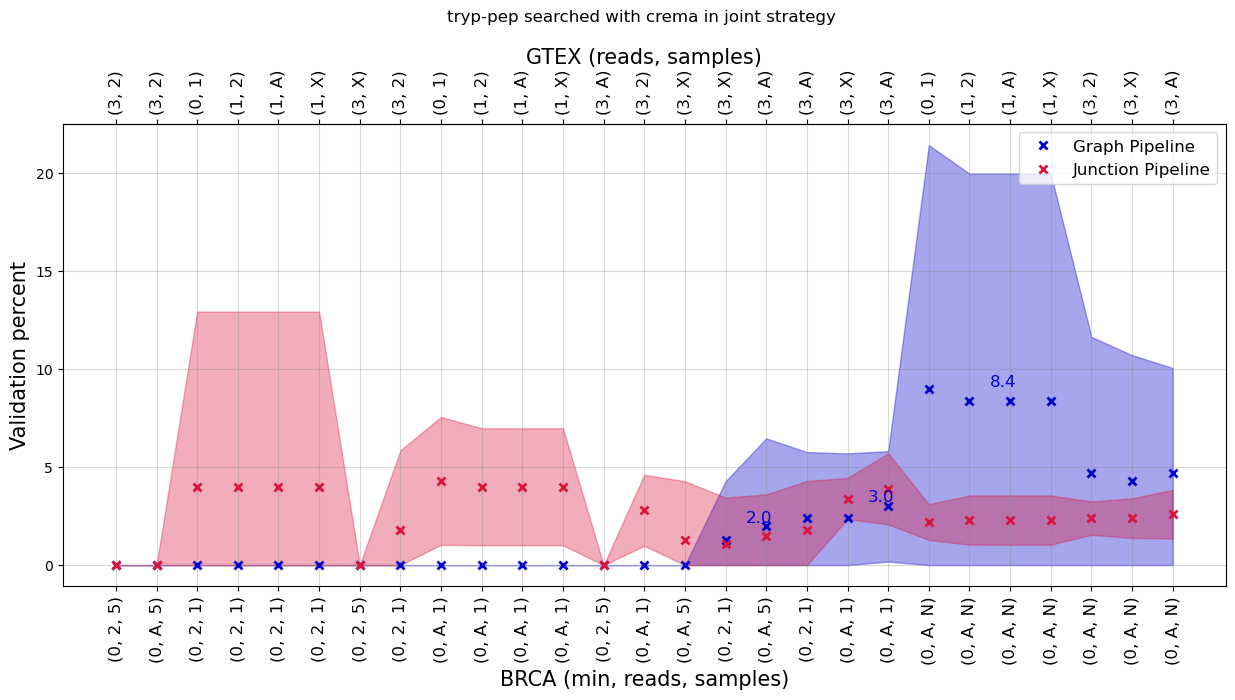

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crema_joint.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              8             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              8             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              8             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  8                  0  
1                      0                  8                  0  
2                      0                  0                  0  
3                      0                  8                  0  
4                      0                  0                  0

(27, 32)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_kmer_crema_joint.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


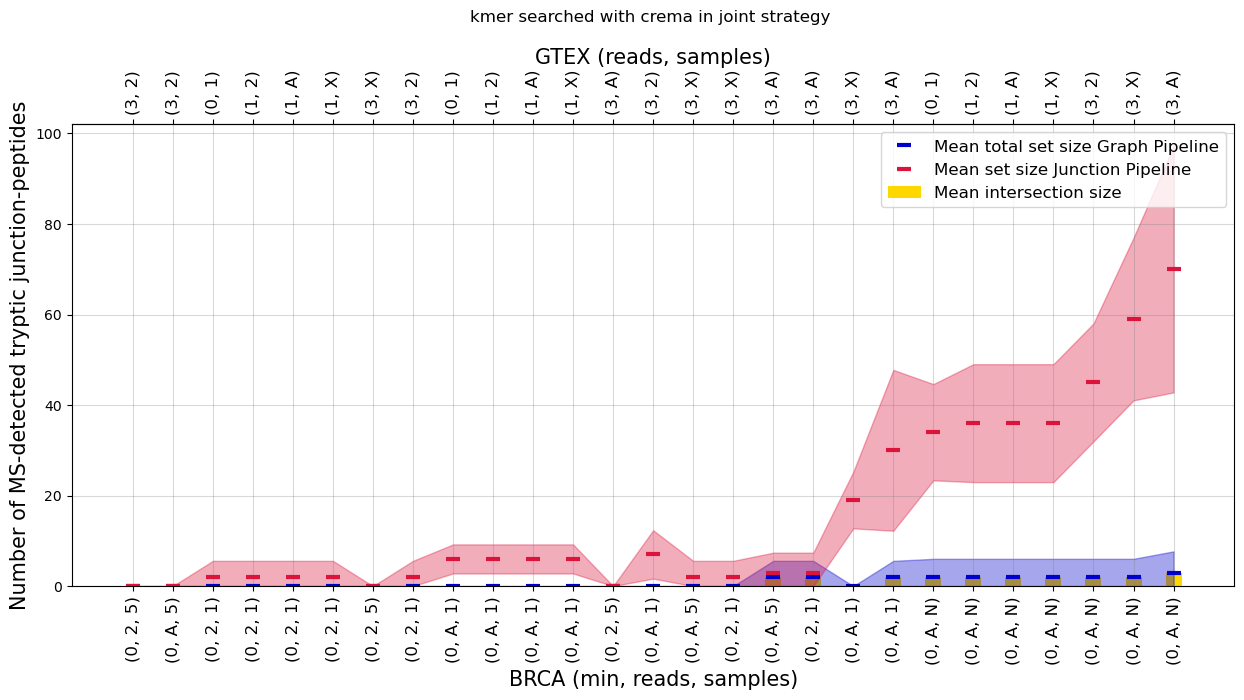

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crema_joint.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              1             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              1             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              1             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  1                  0  
1                      0                  1                  0  
2                      0                  0                  0  
3                      0                  1                  0  
4                      0                  0                  0

(27, 32)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_tryp-pep_crema_joint.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


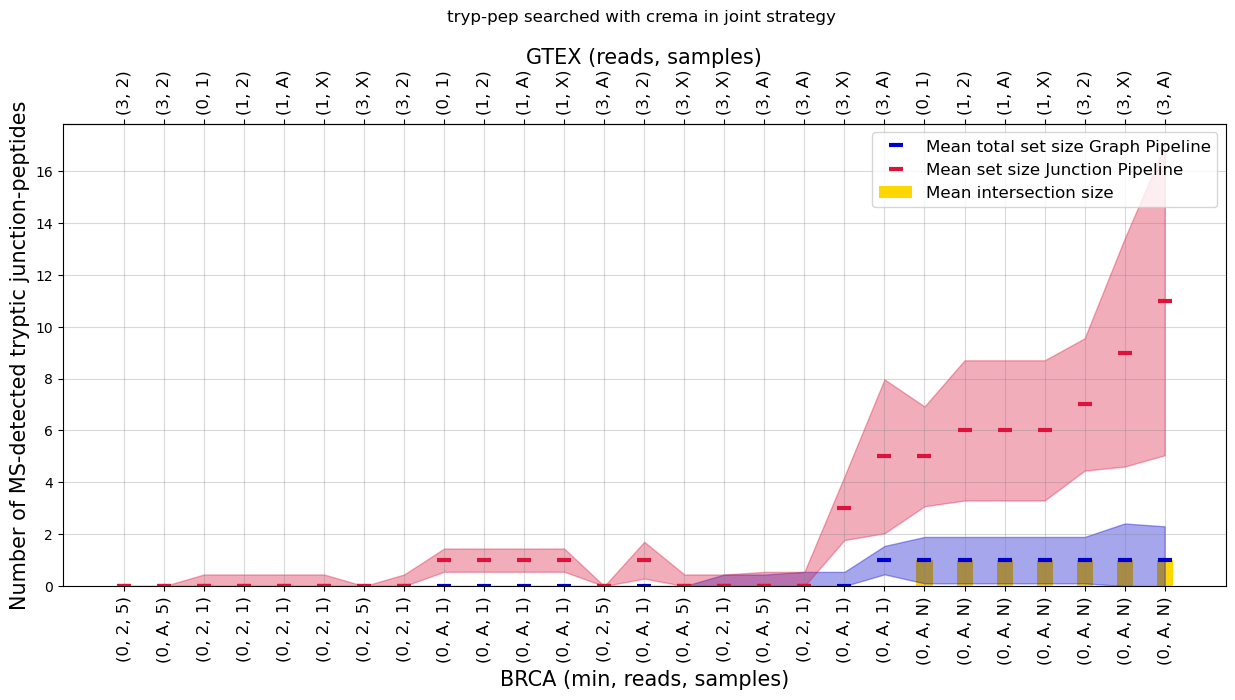

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crema_pool.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU              5.1
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU              5.1
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

(70, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_kmer_crema_pool.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


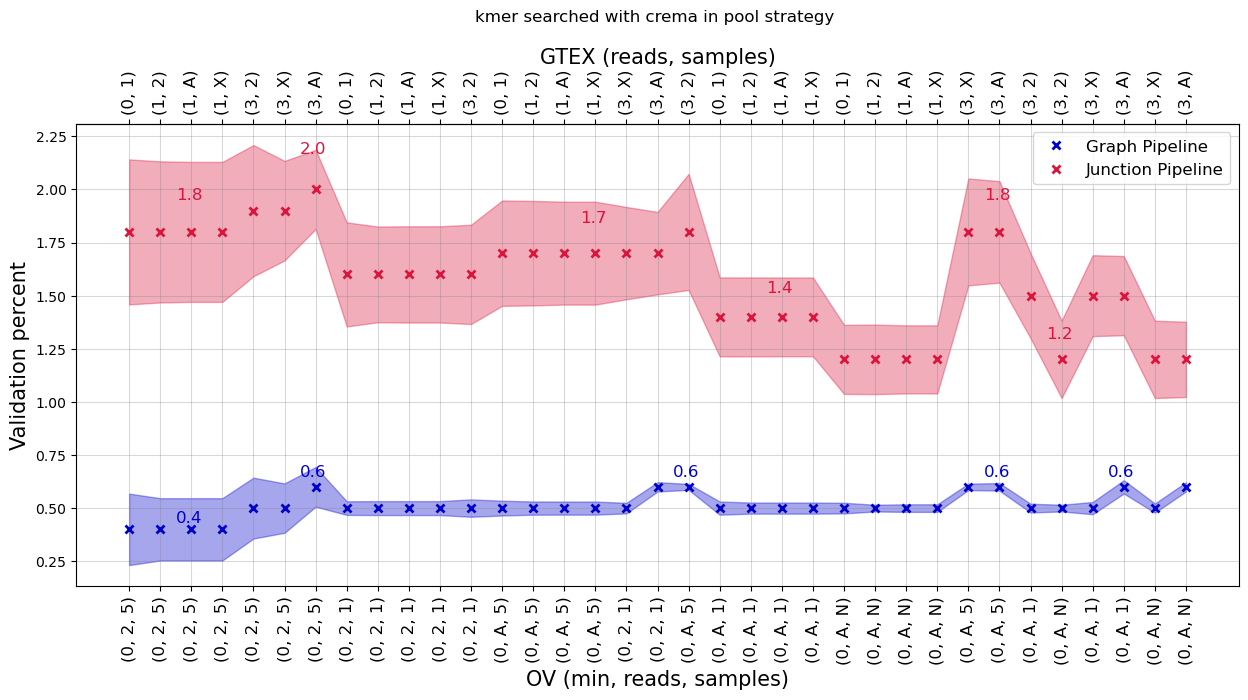

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crema_pool.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU             12.5
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU             12.5
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

(70, 22)


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_tryp-pep_crema_pool.pdf


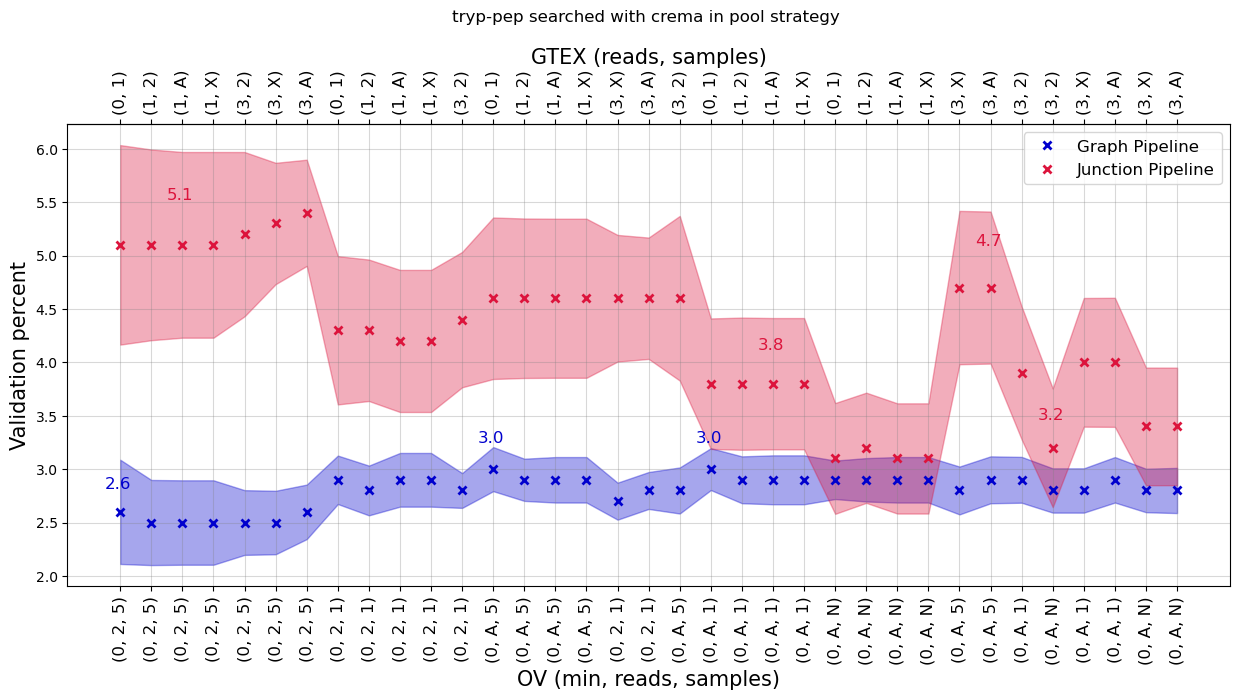

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crema_pool.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              8             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              8             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              8             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  8                  0  
1                      0                  8                  0  
2                      0                  0                  0  
3                      0                  8                  0  
4                      0                  0                  0

(35, 33)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_kmer_crema_pool.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


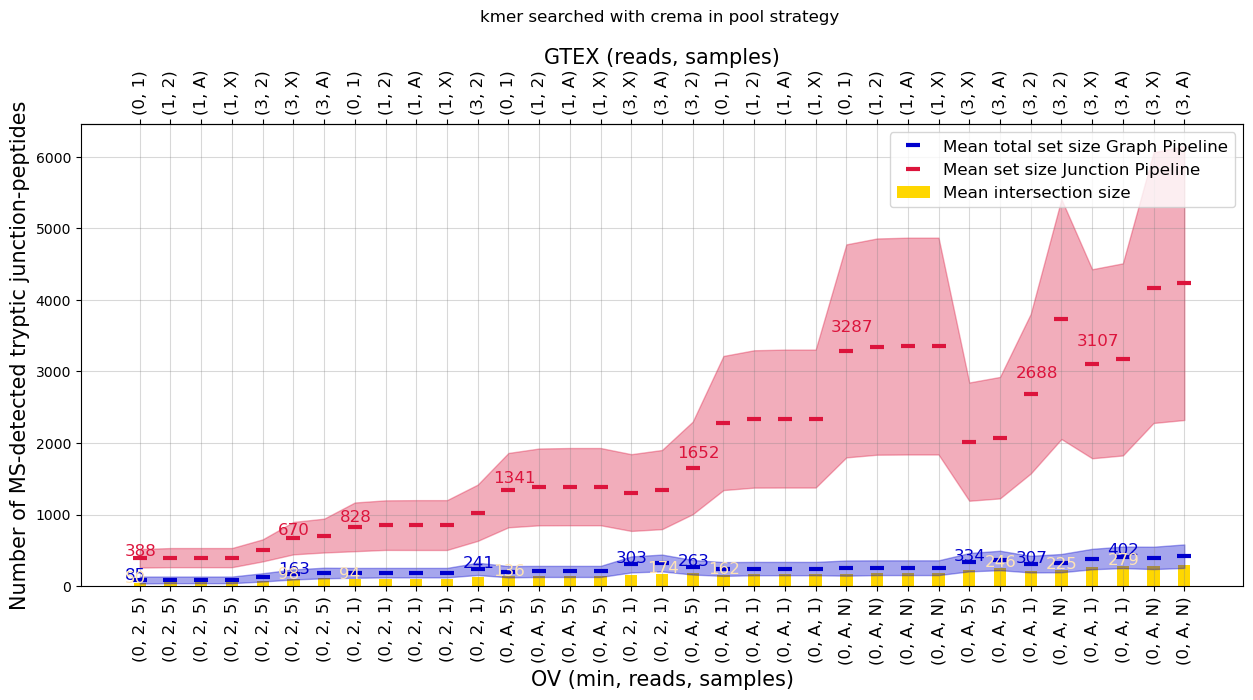

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crema_pool.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              1             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              1             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              1             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  1                  0  
1                      0                  1                  0  
2                      0                  0                  0  
3                      0                  1                  0  
4                      0                  0                  0

(35, 33)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_tryp-pep_crema_pool.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


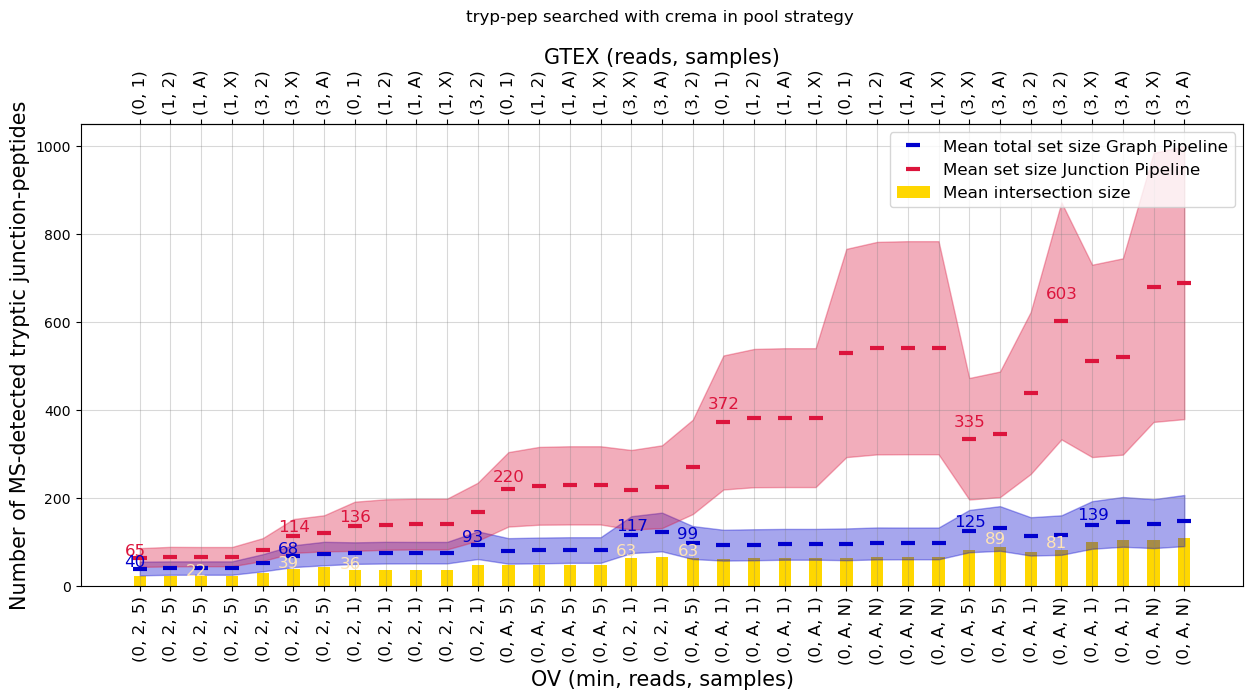

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crema_pool.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU              5.1
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU              5.1
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

(54, 21)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_kmer_crema_pool.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


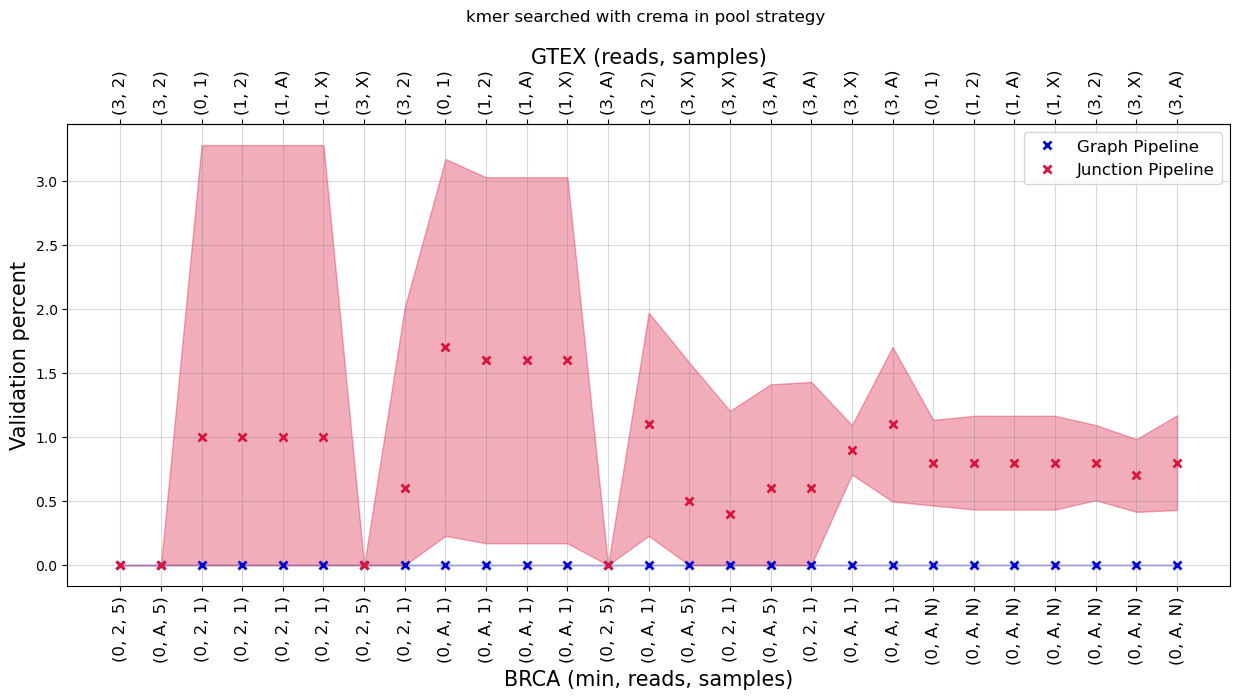

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crema_pool.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU             12.5
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU             12.5
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

(54, 21)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_tryp-pep_crema_pool.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


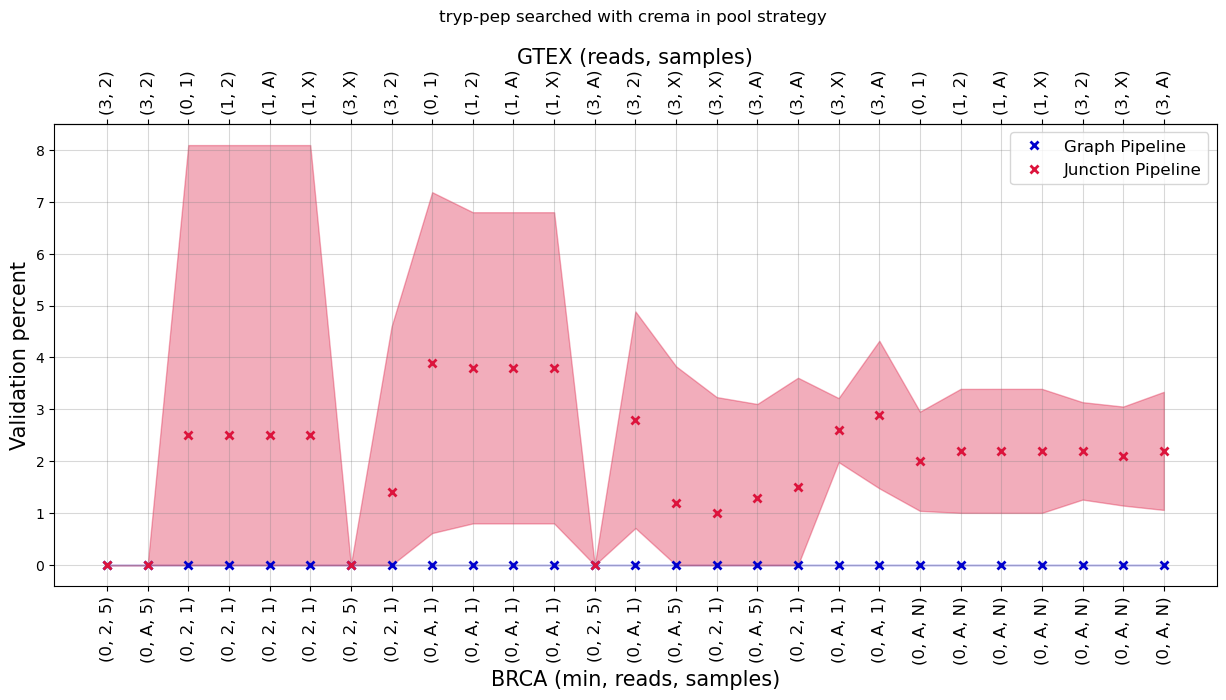

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crema_pool.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              8             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              8             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              8             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  8                  0  
1                      0                  8                  0  
2                      0                  0                  0  
3                      0                  8                  0  
4                      0                  0                  0

(27, 32)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_kmer_crema_pool.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


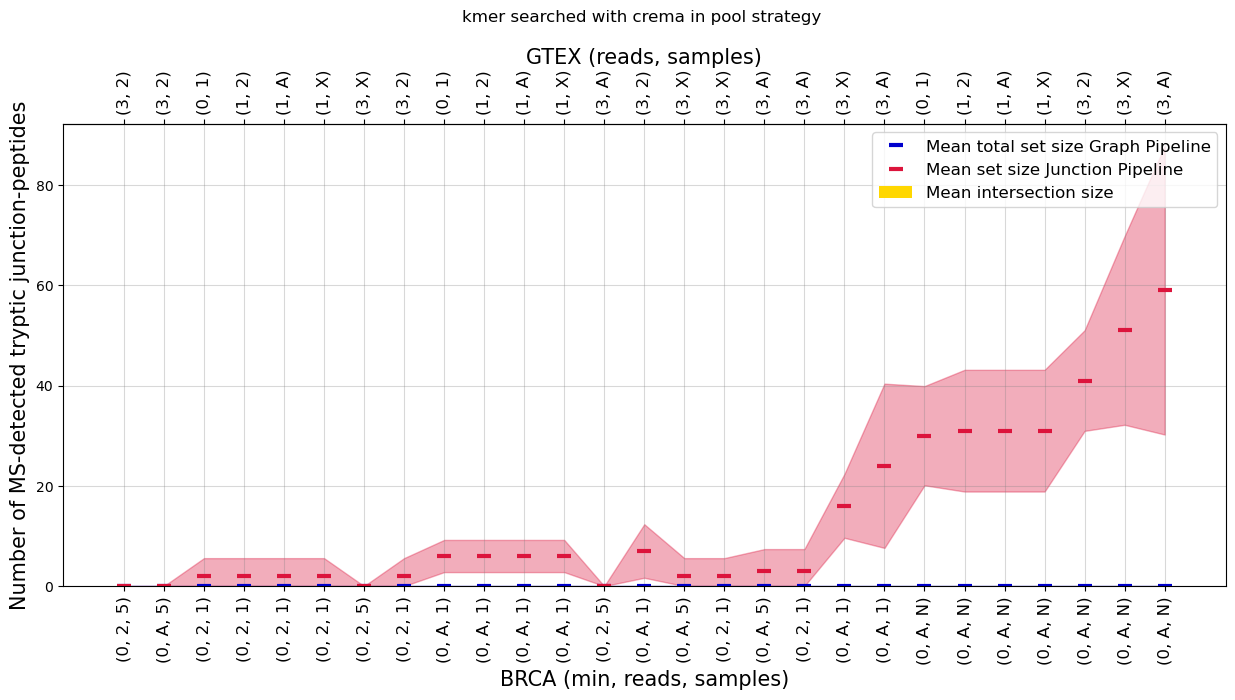

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crema_pool.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              1             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              1             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              1             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  1                  0  
1                      0                  1                  0  
2                      0                  0                  0  
3                      0                  1                  0  
4                      0                  0                  0

/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


(27, 32)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_tryp-pep_crema_pool.pdf


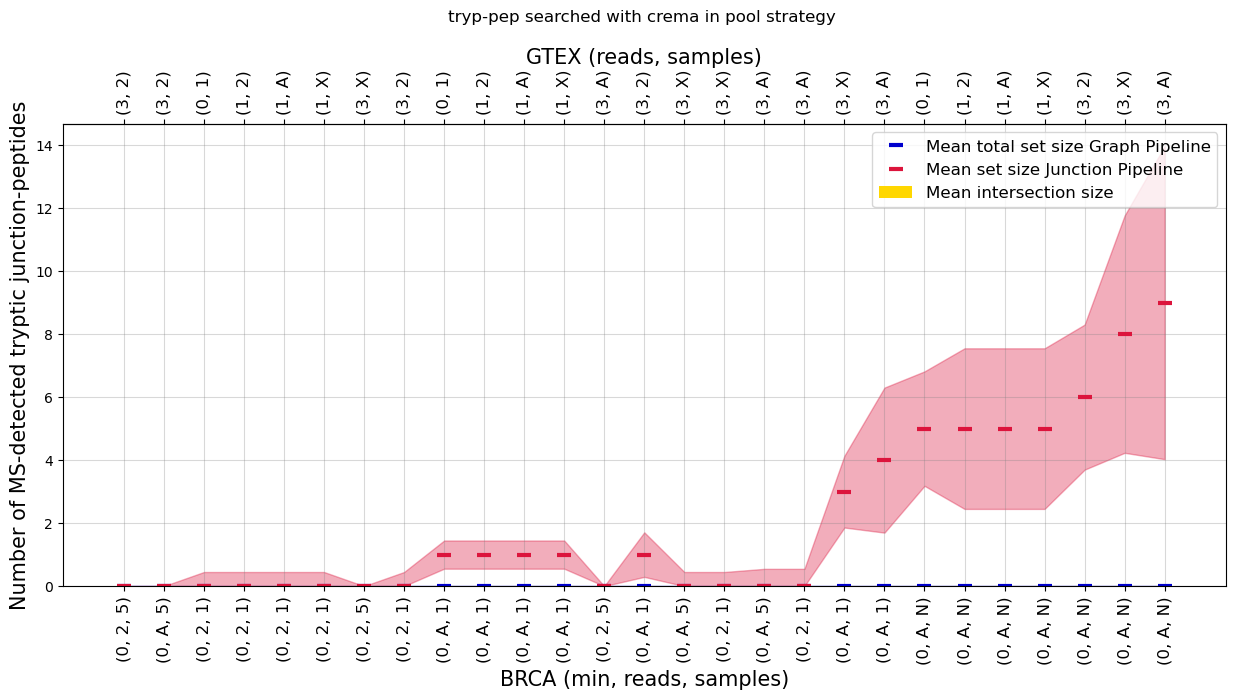

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crema_single.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU              0.0
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU              0.0
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

(70, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_kmer_crema_single.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


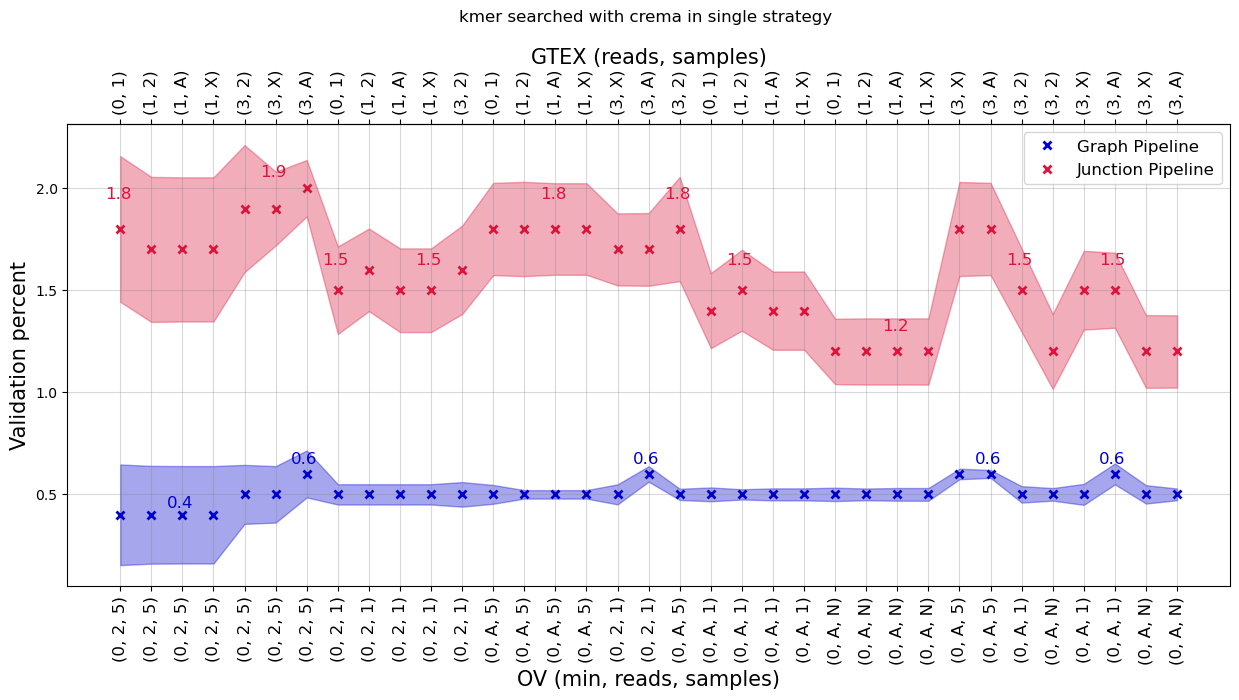

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crema_single.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU              0.0
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU              0.0
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

(70, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_tryp-pep_crema_single.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


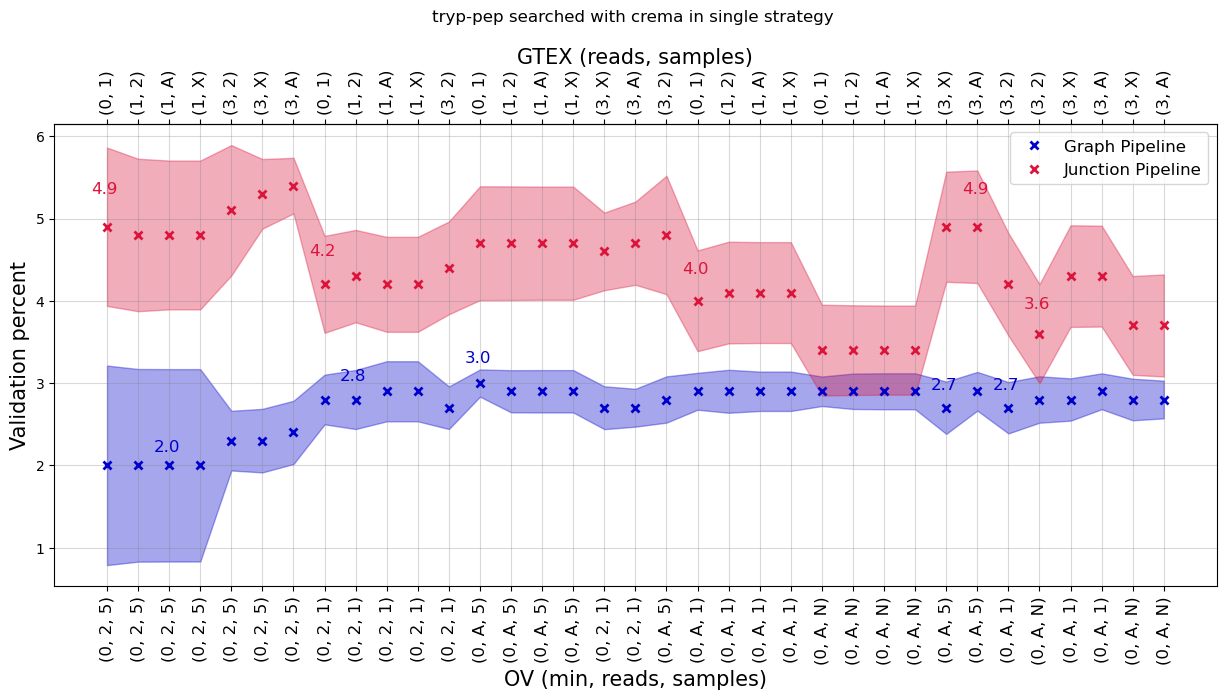

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crema_single.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              0             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              0             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              0             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  0                  0  
1                      0                  0                  0  
2                      0                  0                  0  
3                      0                  0                  0  
4                      0                  0                  0

(35, 33)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_kmer_crema_single.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


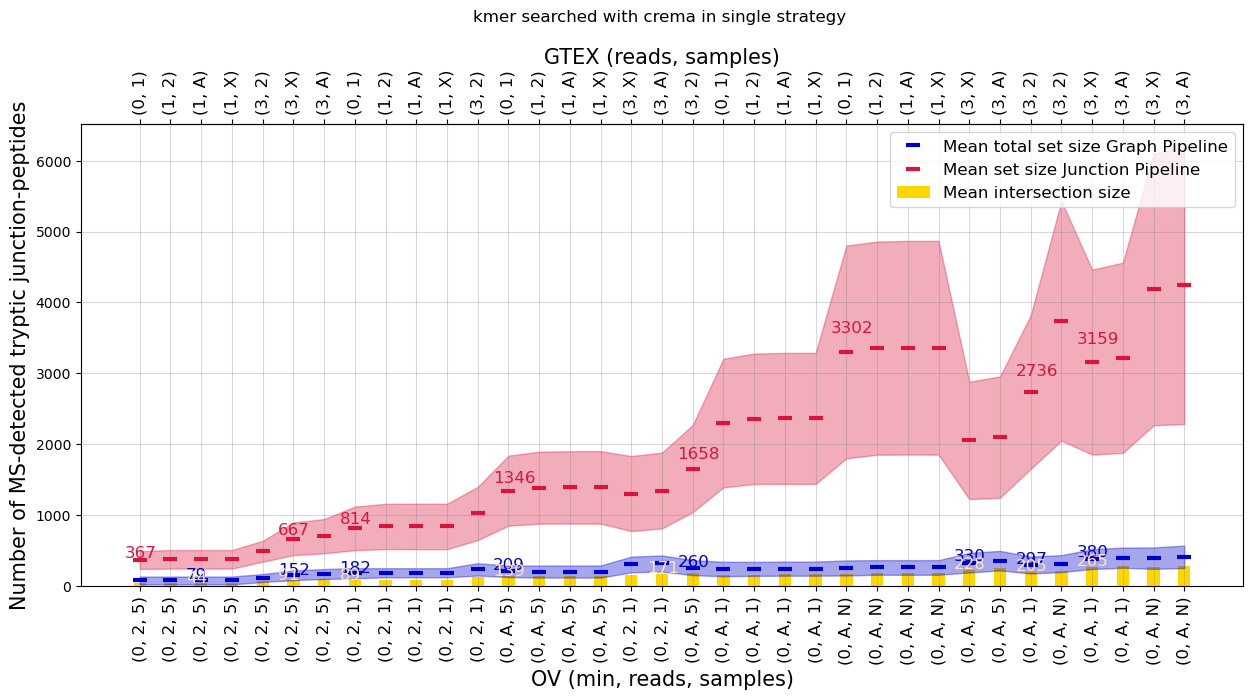

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crema_single.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              0             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              0             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              0             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  0                  0  
1                      0                  0                  0  
2                      0                  0                  0  
3                      0                  0                  0  
4                      0                  0                  0

(35, 33)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_tryp-pep_crema_single.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


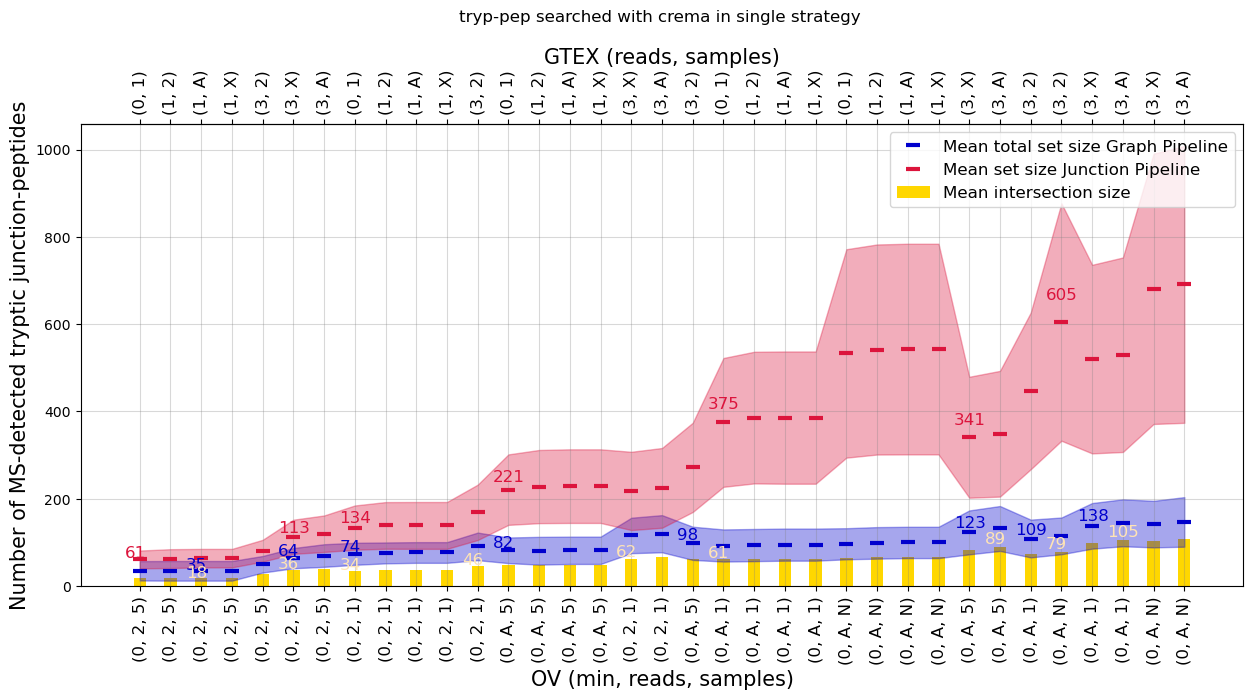

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crema_single.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU              0.0
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU              0.0
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


(54, 21)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_kmer_crema_single.pdf


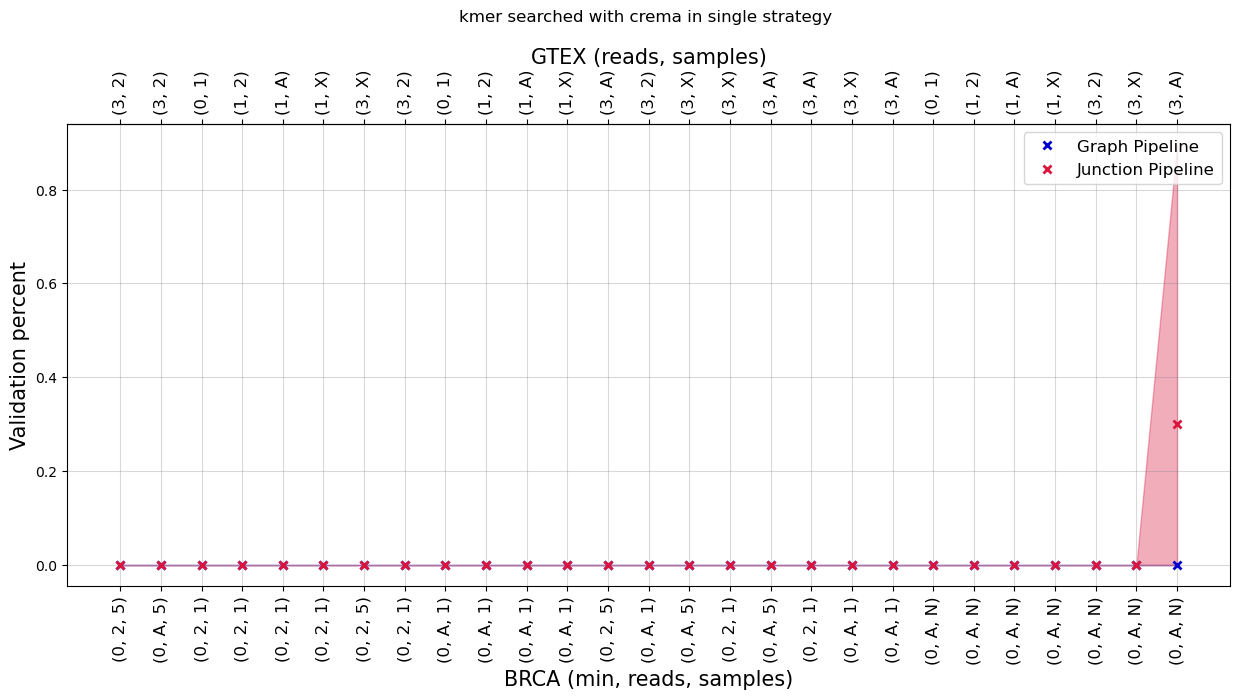

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crema_single.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU              0.0
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU              0.0
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

(54, 21)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_tryp-pep_crema_single.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


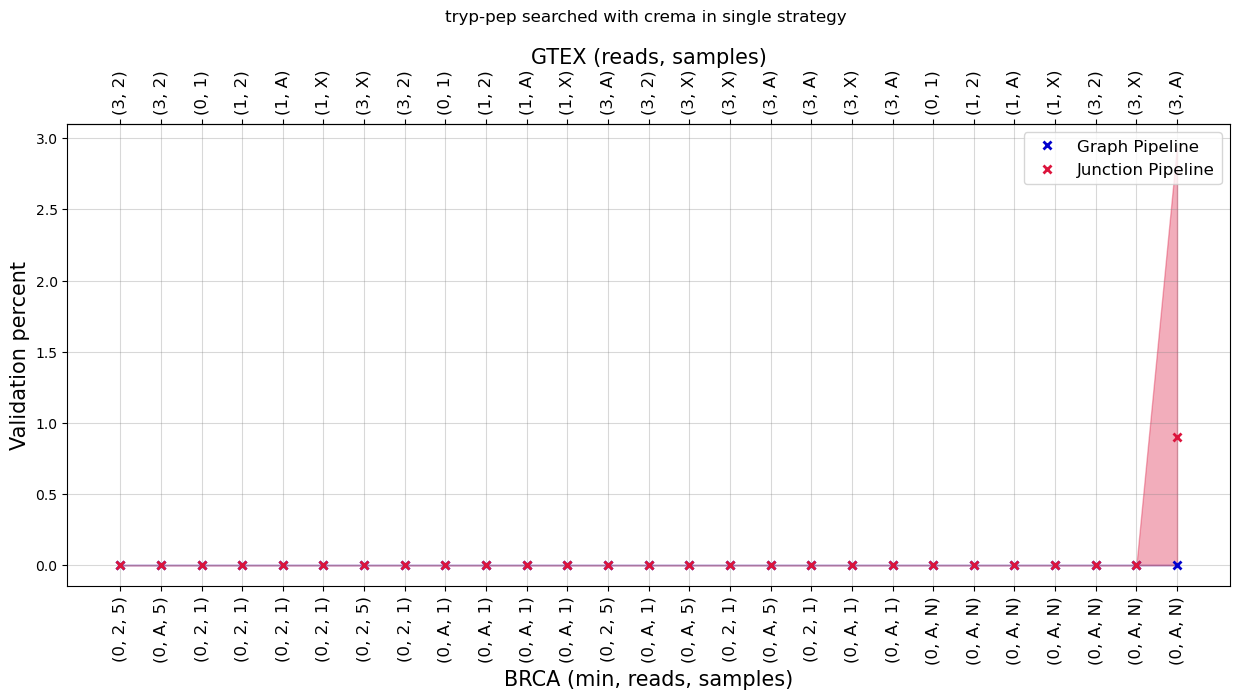

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crema_single.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              0             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              0             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              0             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  0                  0  
1                      0                  0                  0  
2                      0                  0                  0  
3                      0                  0                  0  
4                      0                  0                  0

(27, 32)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_kmer_crema_single.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


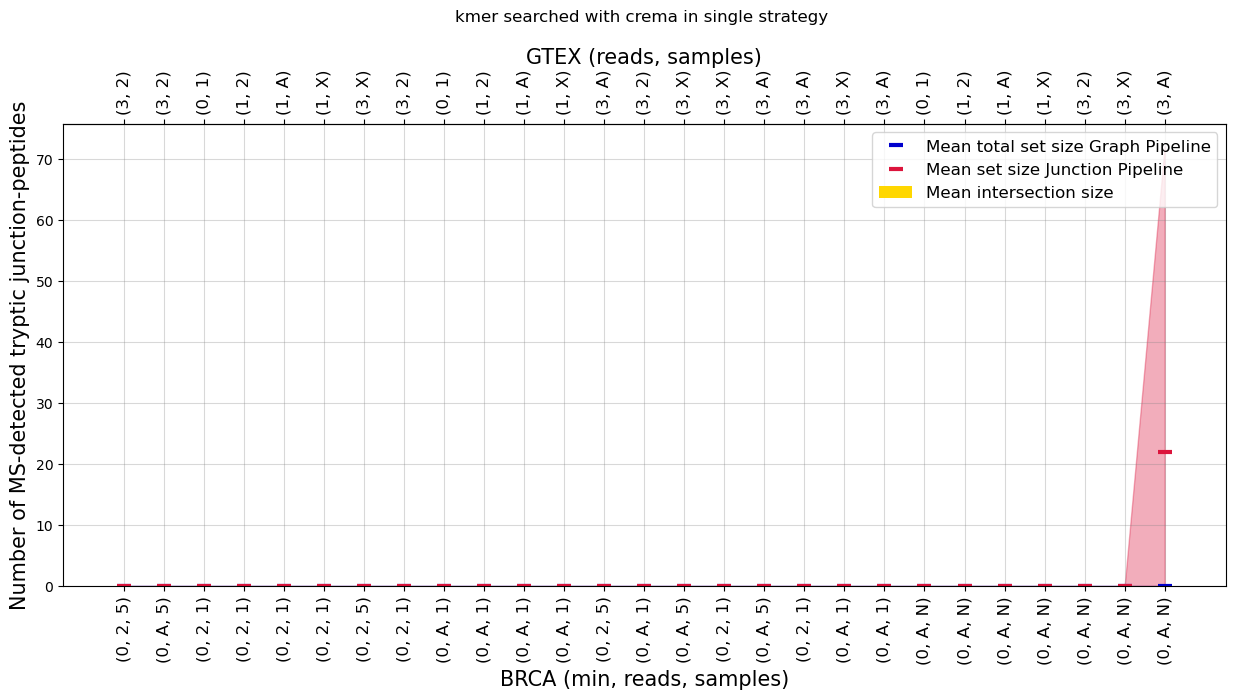

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crema_single.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              0             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              0             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              0             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  0                  0  
1                      0                  0                  0  
2                      0                  0                  0  
3                      0                  0                  0  
4                      0                  0                  0

(27, 32)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_tryp-pep_crema_single.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


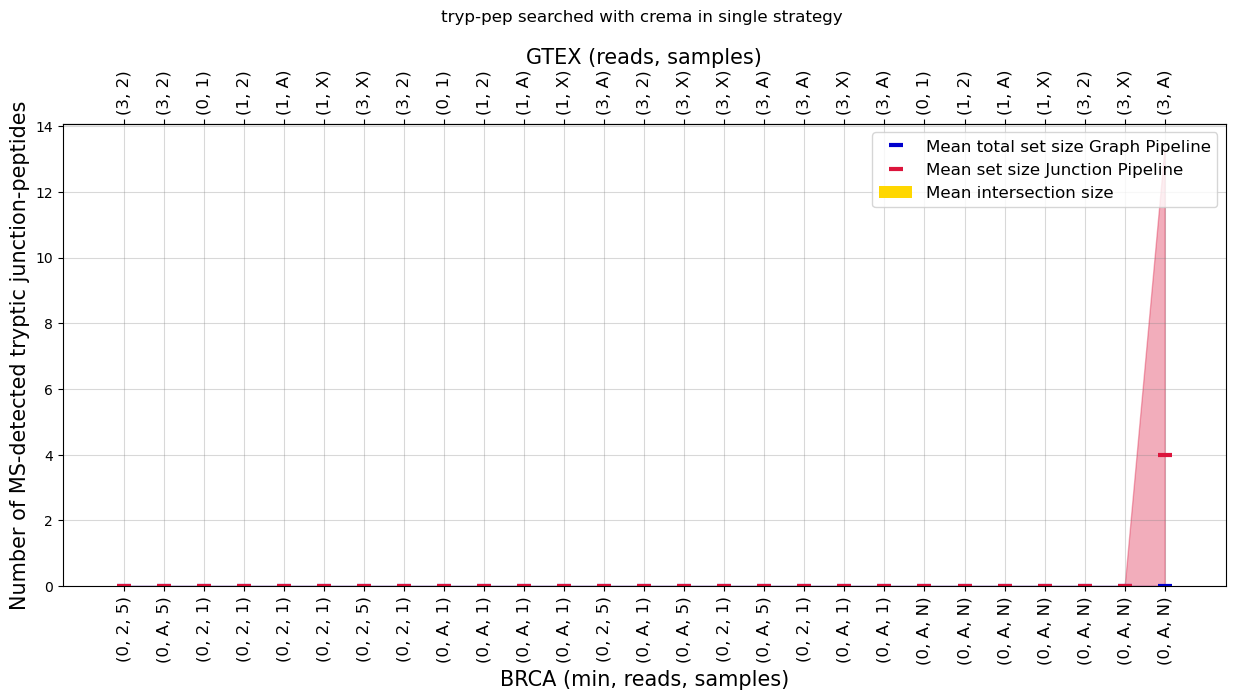

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crux_joint.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU              5.1
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU              5.1
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

(70, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_kmer_crux_joint.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


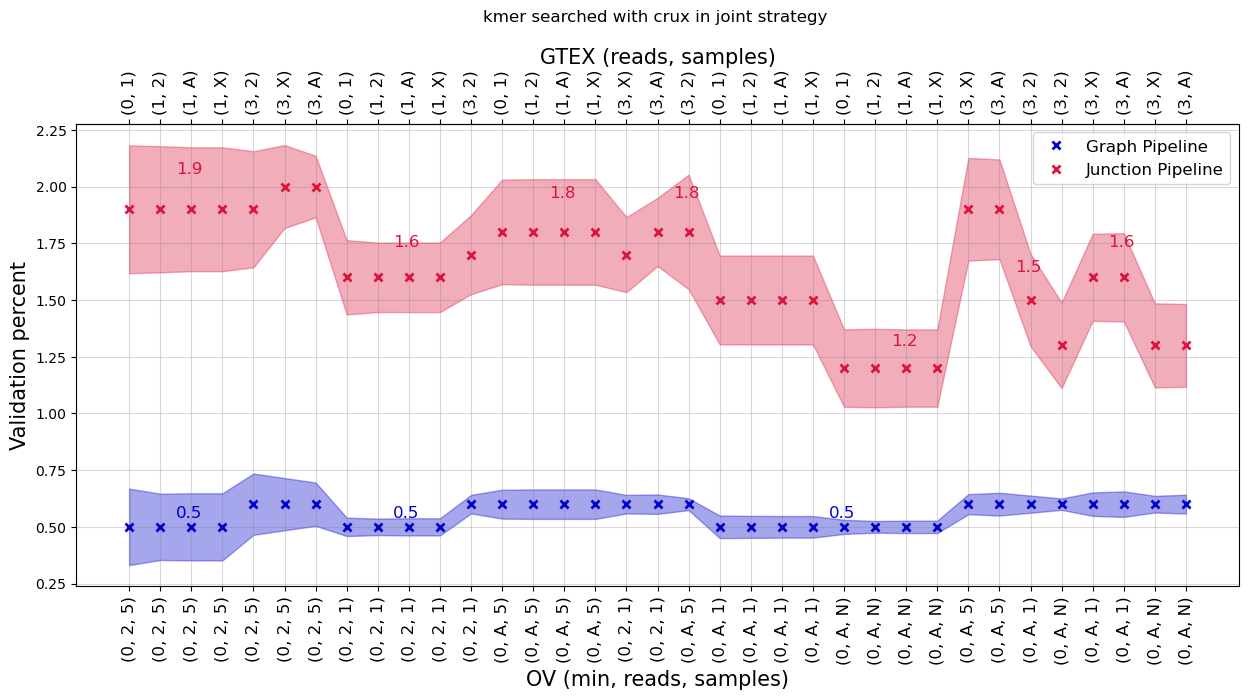

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crux_joint.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH             0.00
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU             7.69
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH             0.00
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU             7.69
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH             0.00

/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


(70, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_tryp-pep_crux_joint.pdf


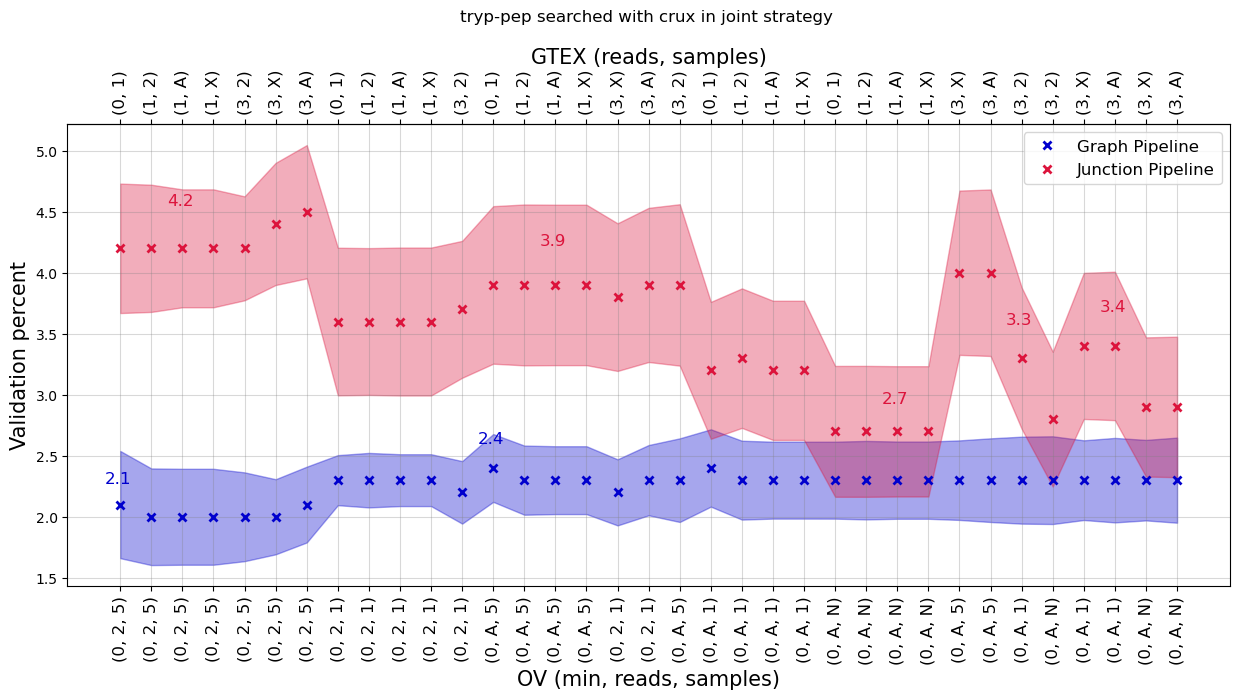

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crux_joint.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              8             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              8             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA             17             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  8                  0  
1                      0                  8                  0  
2                      0                  0                  0  
3                      0                 17                  0  
4                      0                  0                  0

(35, 33)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_kmer_crux_joint.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


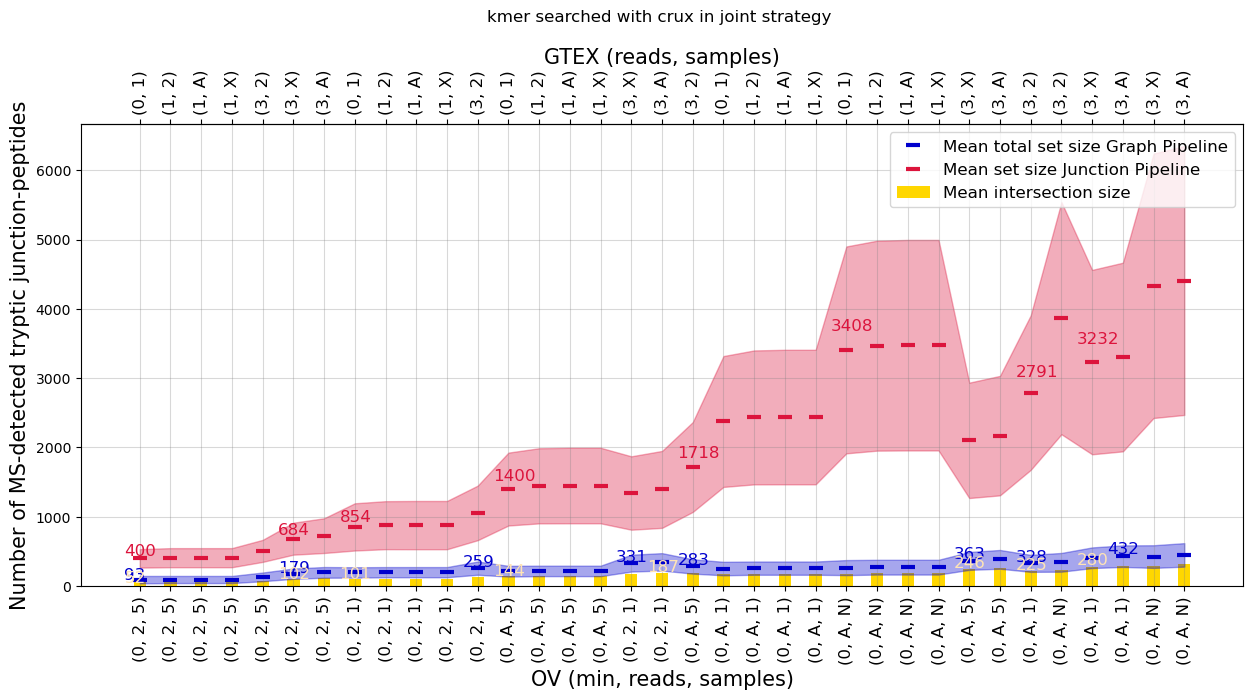

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crux_joint.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              1             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              1             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              2             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  1                  0  
1                      0                  1                  0  
2                      0                  0                  0  
3                      0                  2                  0  
4                      0                  0                  0

(35, 33)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_tryp-pep_crux_joint.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


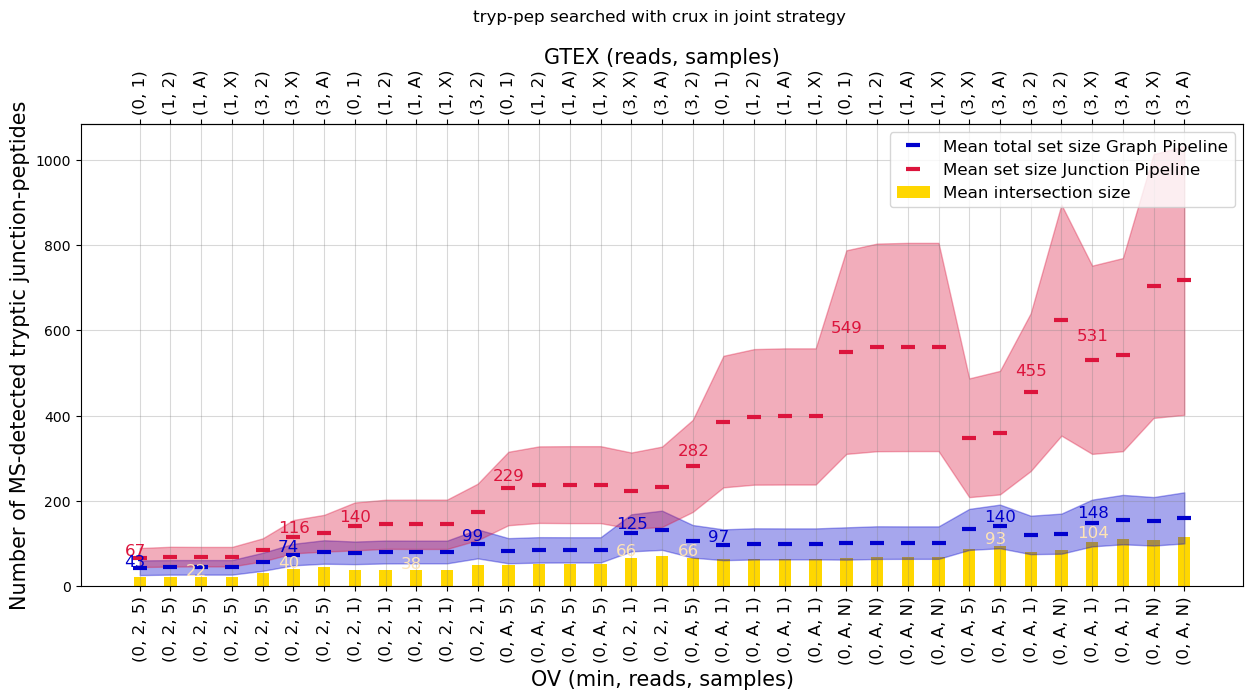

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crux_joint.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU              5.1
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU              5.1
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

(54, 21)


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_kmer_crux_joint.pdf


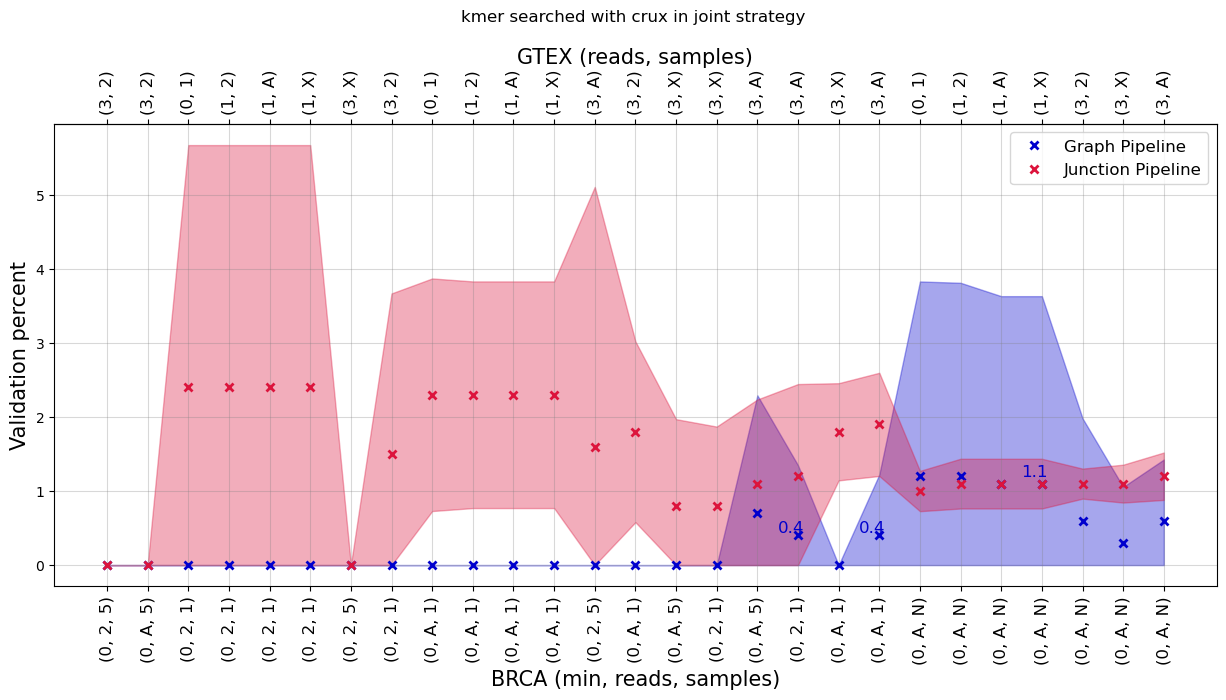

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crux_joint.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH             0.00
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU             7.69
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH             0.00
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU             7.69
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH             0.00

(54, 21)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_tryp-pep_crux_joint.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


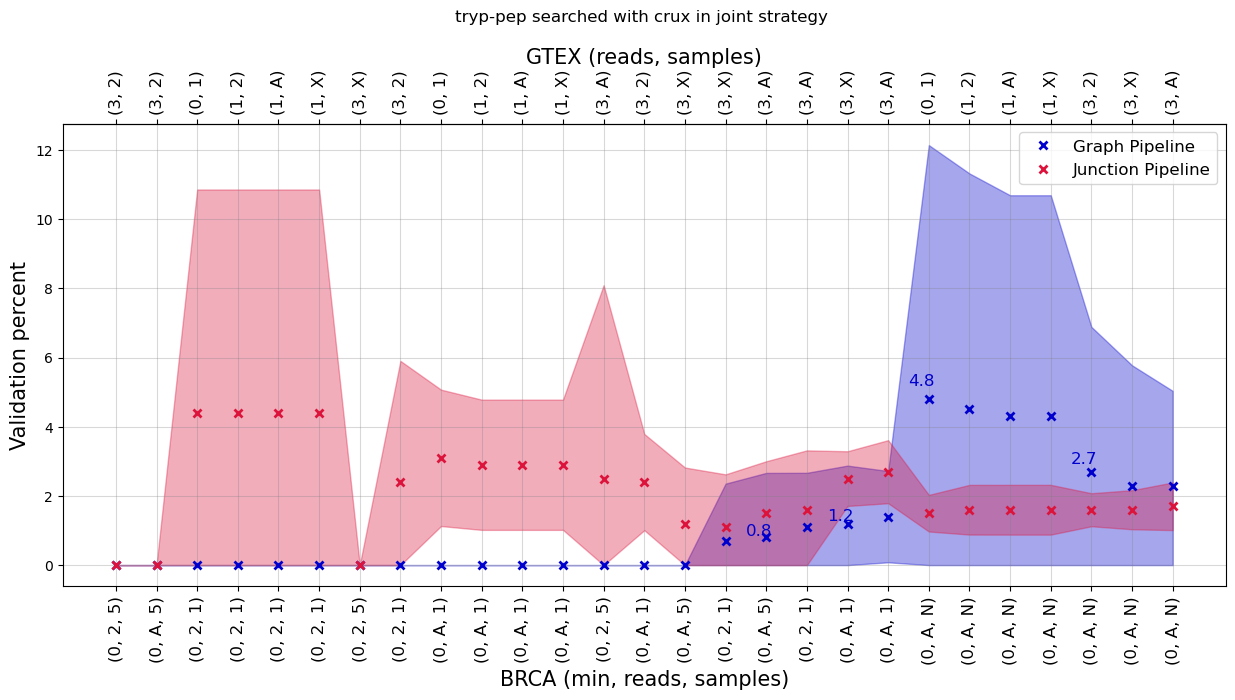

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crux_joint.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              8             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              8             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA             17             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  8                  0  
1                      0                  8                  0  
2                      0                  0                  0  
3                      0                 17                  0  
4                      0                  0                  0

(27, 32)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_kmer_crux_joint.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


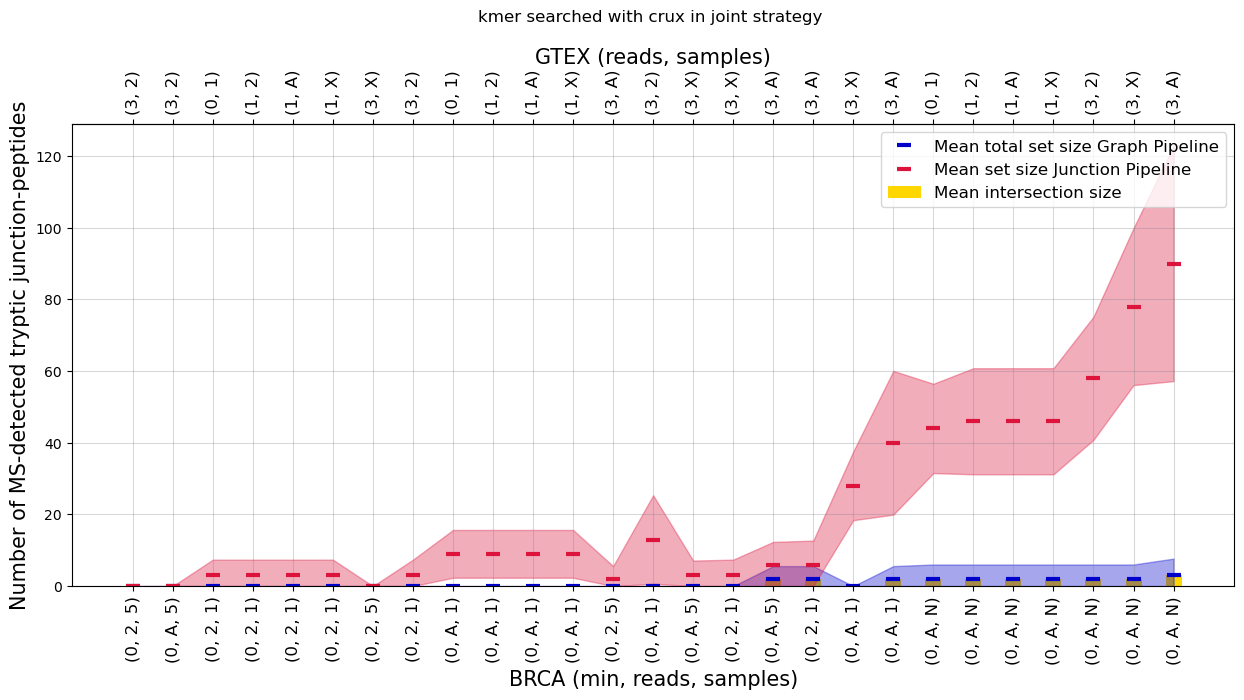

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crux_joint.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              1             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              1             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              2             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  1                  0  
1                      0                  1                  0  
2                      0                  0                  0  
3                      0                  2                  0  
4                      0                  0                  0

(27, 32)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_tryp-pep_crux_joint.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


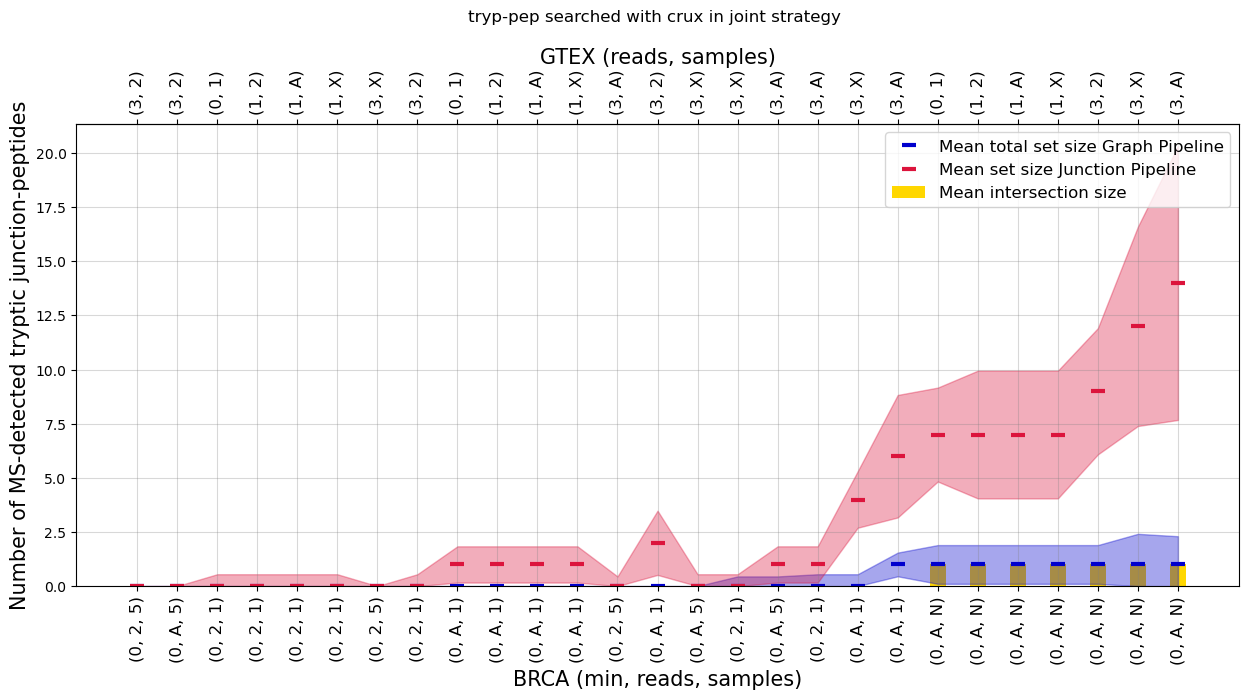

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crux_pool.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU              5.1
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU              5.1
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

(70, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_kmer_crux_pool.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


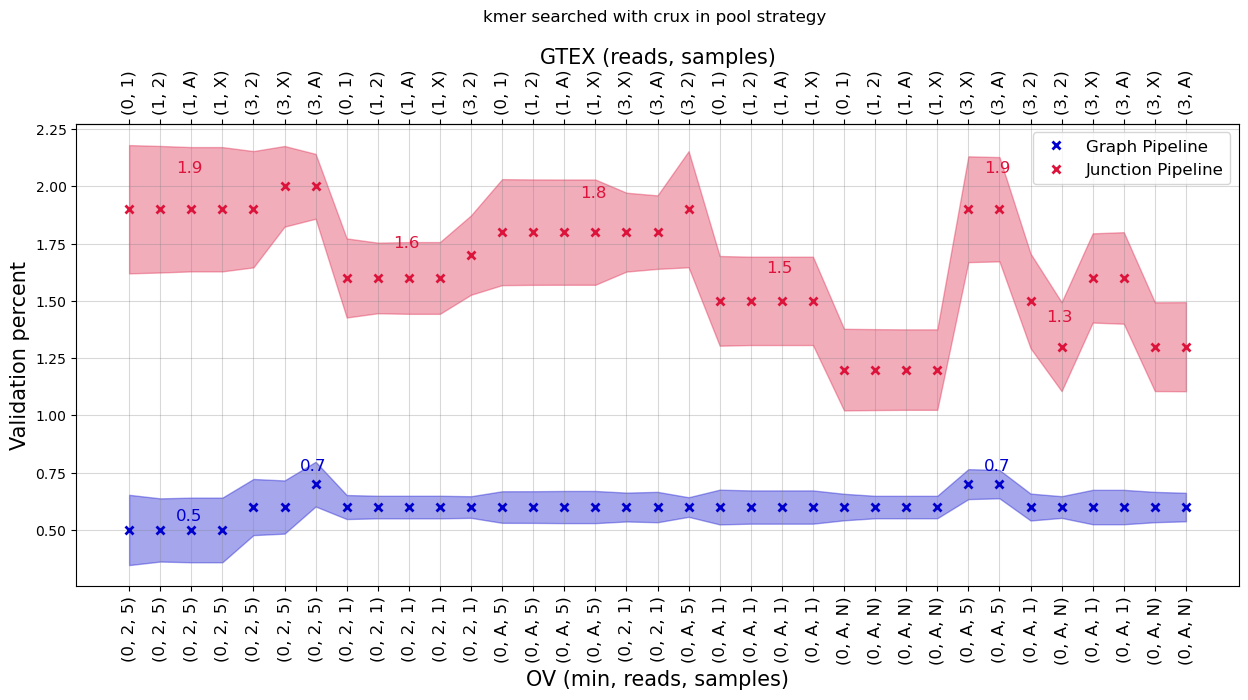

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crux_pool.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH             0.00
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU             7.14
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH             0.00
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU             7.14
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH             0.00

(70, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_tryp-pep_crux_pool.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


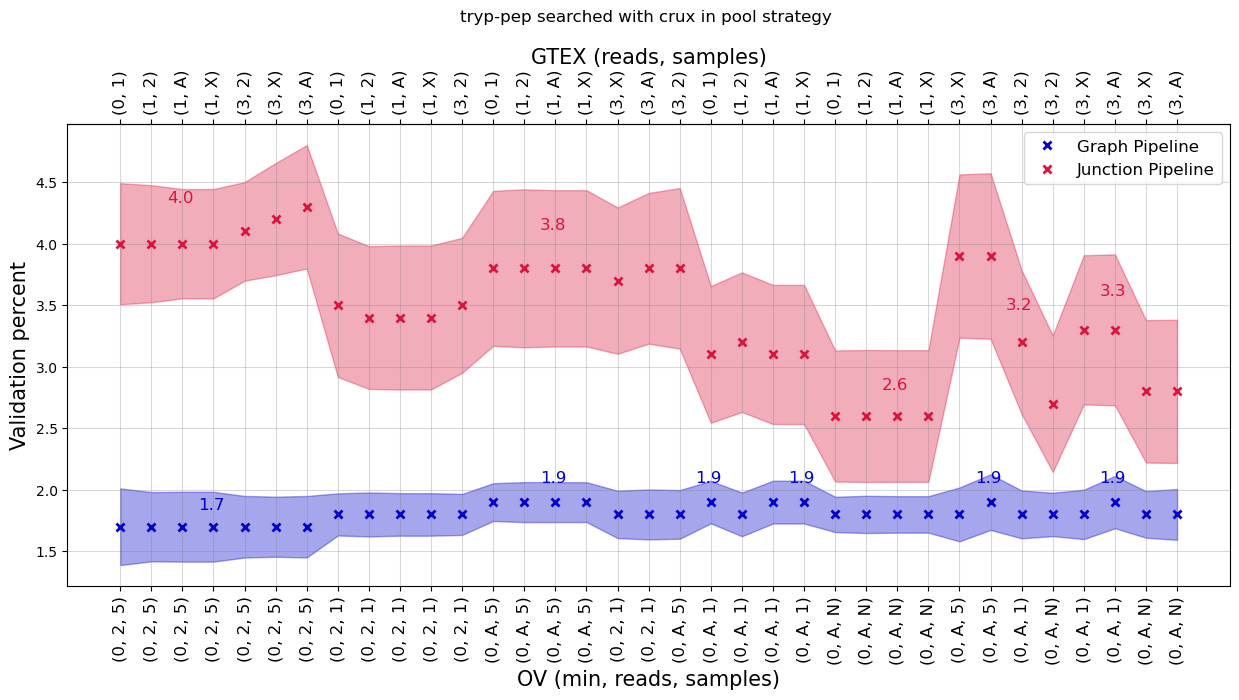

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crux_pool.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              8             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              8             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              8             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  8                  0  
1                      0                  8                  0  
2                      0                  0                  0  
3                      0                  8                  0  
4                      0                  0                  0

(35, 33)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_kmer_crux_pool.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


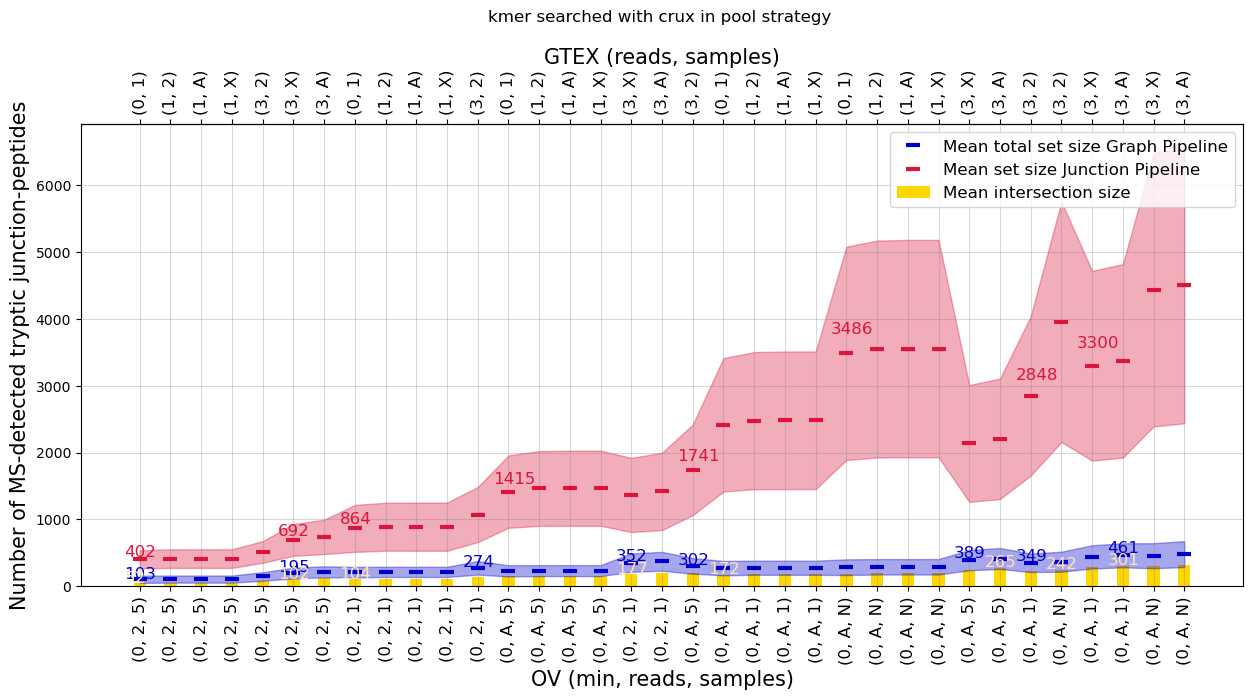

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crux_pool.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              1             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              1             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              1             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  1                  0  
1                      0                  1                  0  
2                      0                  0                  0  
3                      0                  1                  0  
4                      0                  0                  0

/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


(35, 33)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_tryp-pep_crux_pool.pdf


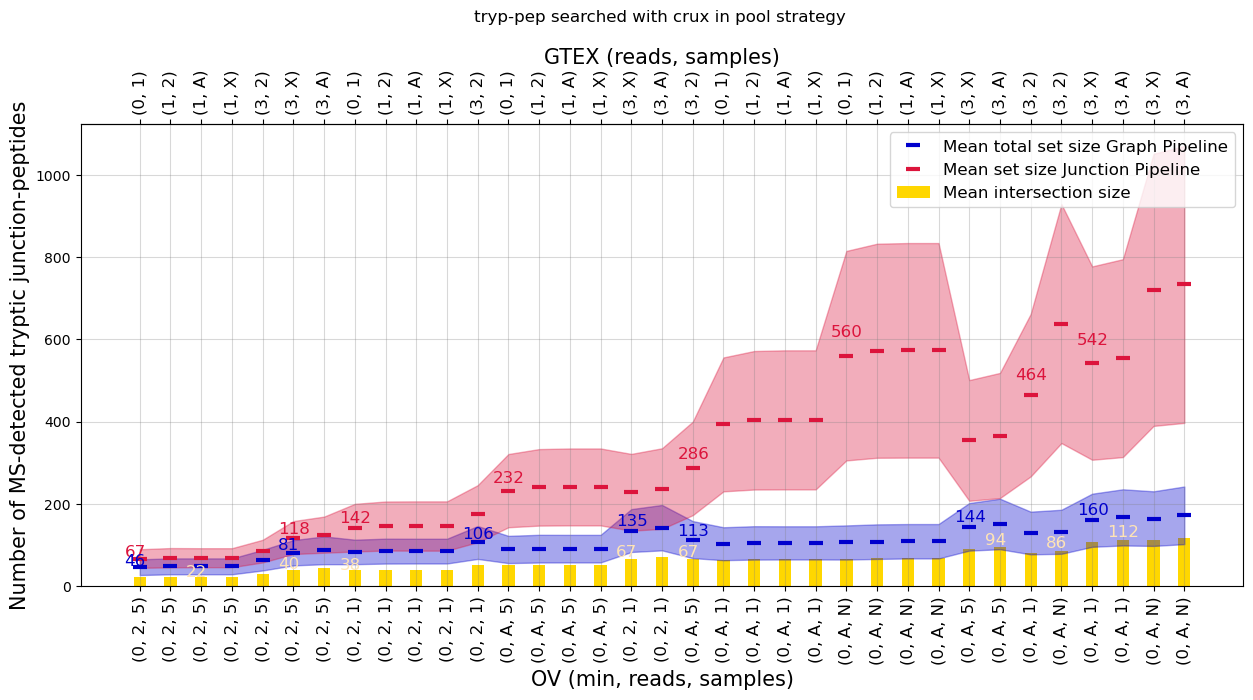

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crux_pool.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU              5.1
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU              5.1
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

(54, 21)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_kmer_crux_pool.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


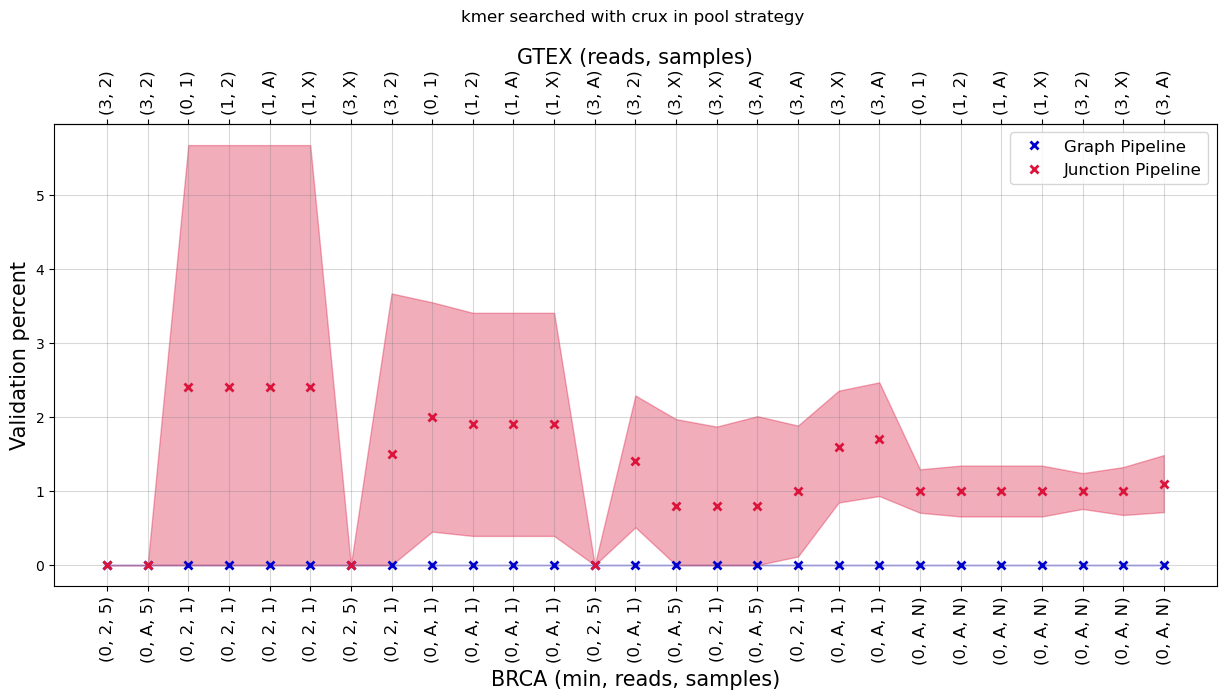

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crux_pool.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH             0.00
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU             7.14
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH             0.00
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU             7.14
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH             0.00

(54, 21)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_tryp-pep_crux_pool.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


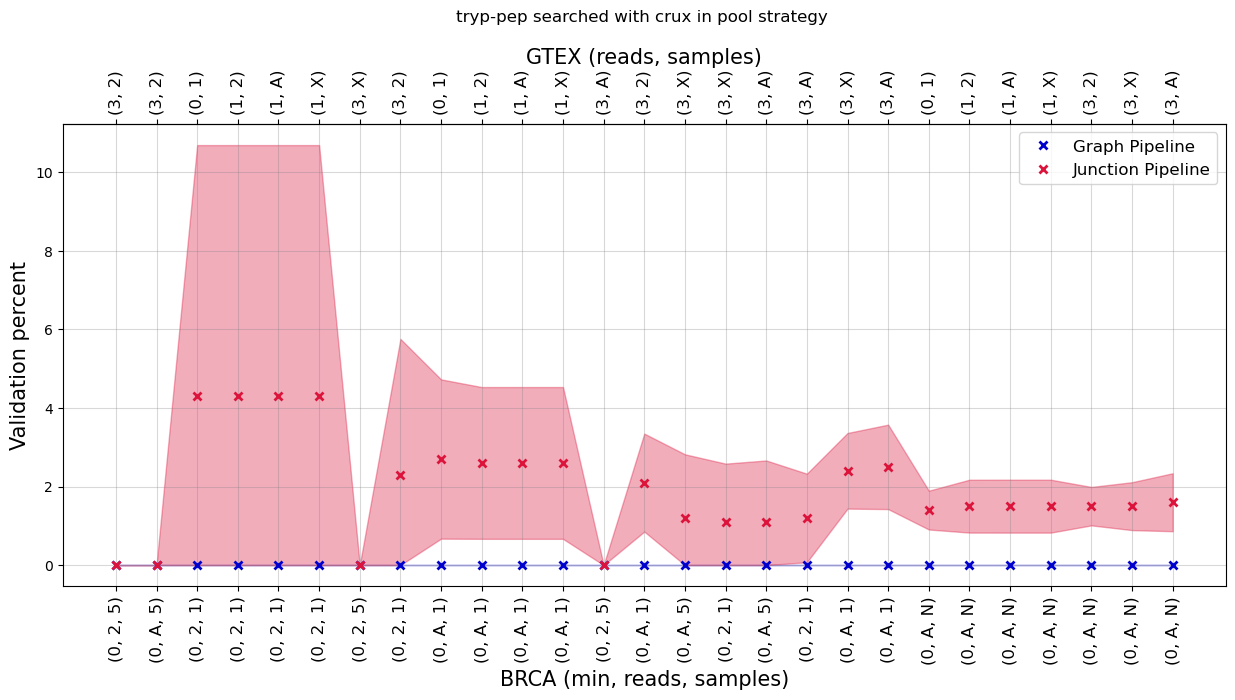

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crux_pool.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              8             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              8             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              8             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  8                  0  
1                      0                  8                  0  
2                      0                  0                  0  
3                      0                  8                  0  
4                      0                  0                  0

(27, 32)


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_kmer_crux_pool.pdf


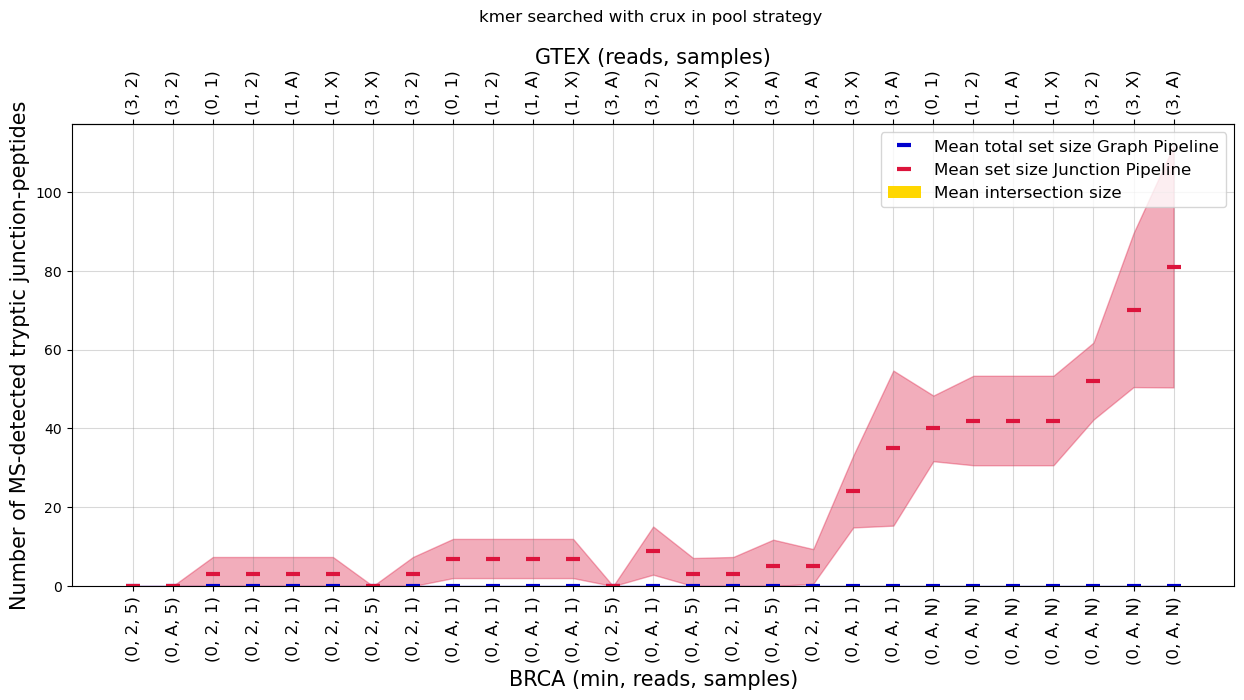

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crux_pool.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              1             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              1             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              1             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  1                  0  
1                      0                  1                  0  
2                      0                  0                  0  
3                      0                  1                  0  
4                      0                  0                  0

(27, 32)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_tryp-pep_crux_pool.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


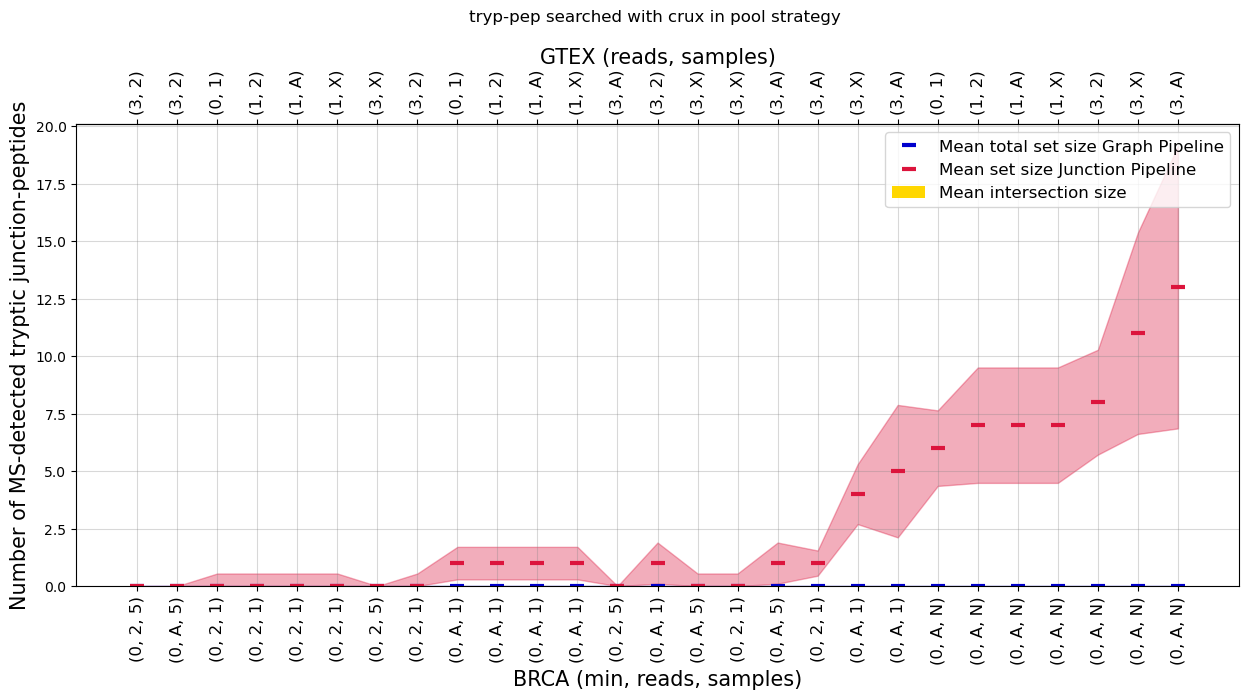

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crux_single.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU              0.0
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU              0.0
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

(70, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_kmer_crux_single.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


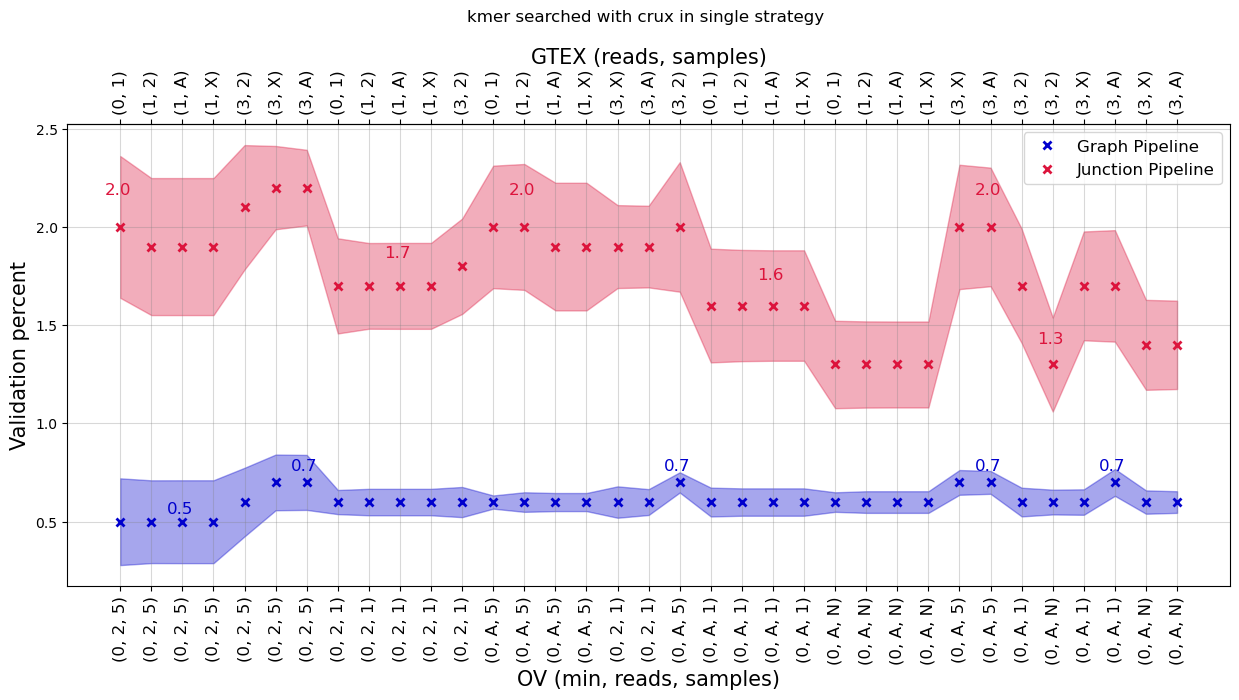

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crux_single.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU              0.0
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU              0.0
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

(70, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_tryp-pep_crux_single.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


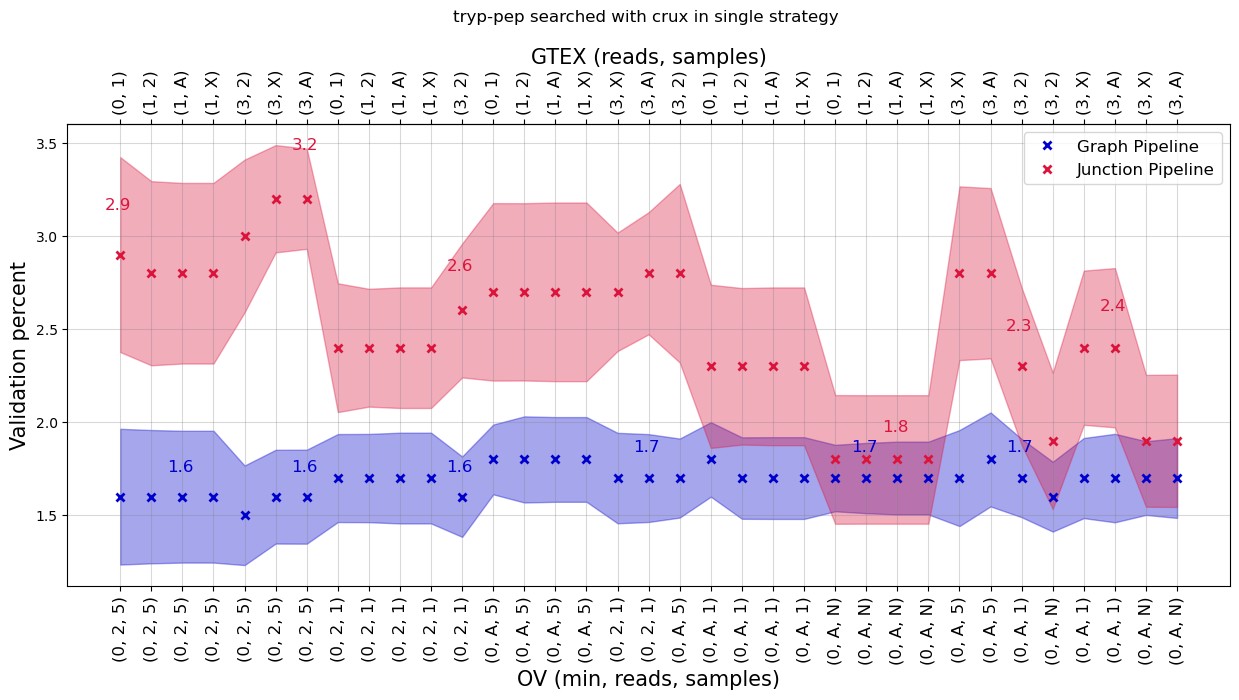

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crux_single.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              0             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              0             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              0             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  0                  0  
1                      0                  0                  0  
2                      0                  0                  0  
3                      0                  0                  0  
4                      0                  0                  0

(35, 33)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_kmer_crux_single.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


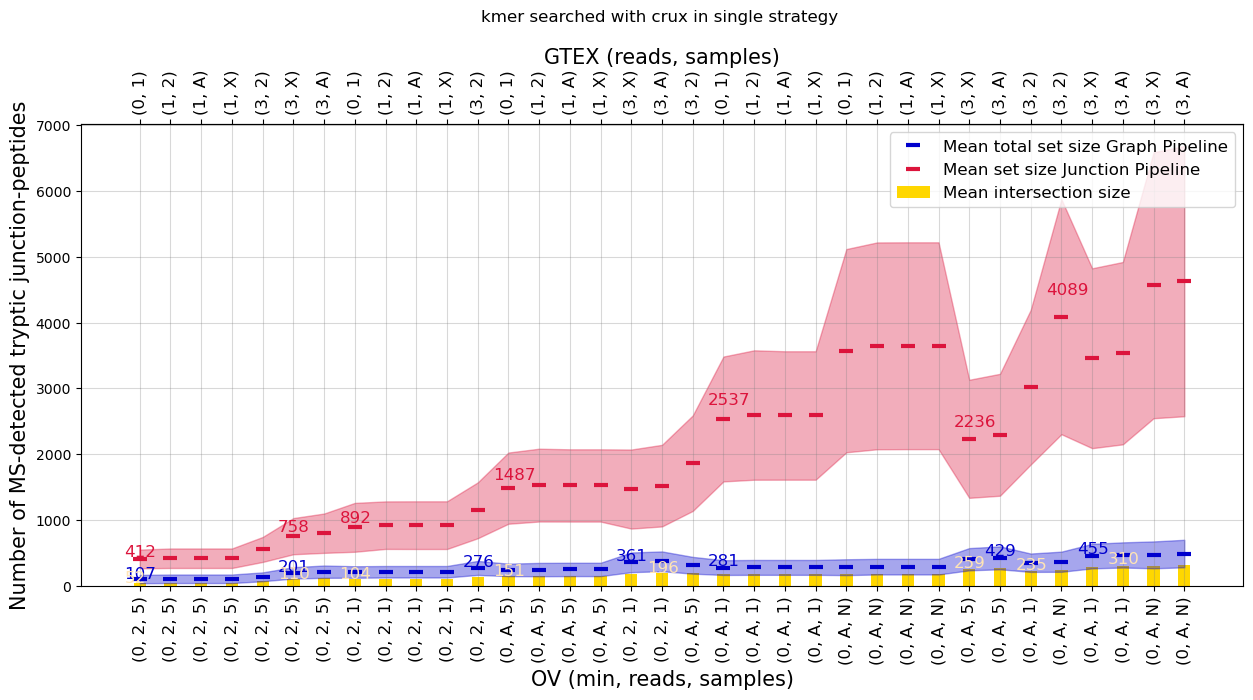

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crux_single.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              0             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              0             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              0             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  0                  0  
1                      0                  0                  0  
2                      0                  0                  0  
3                      0                  0                  0  
4                      0                  0                  0

(35, 33)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_tryp-pep_crux_single.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


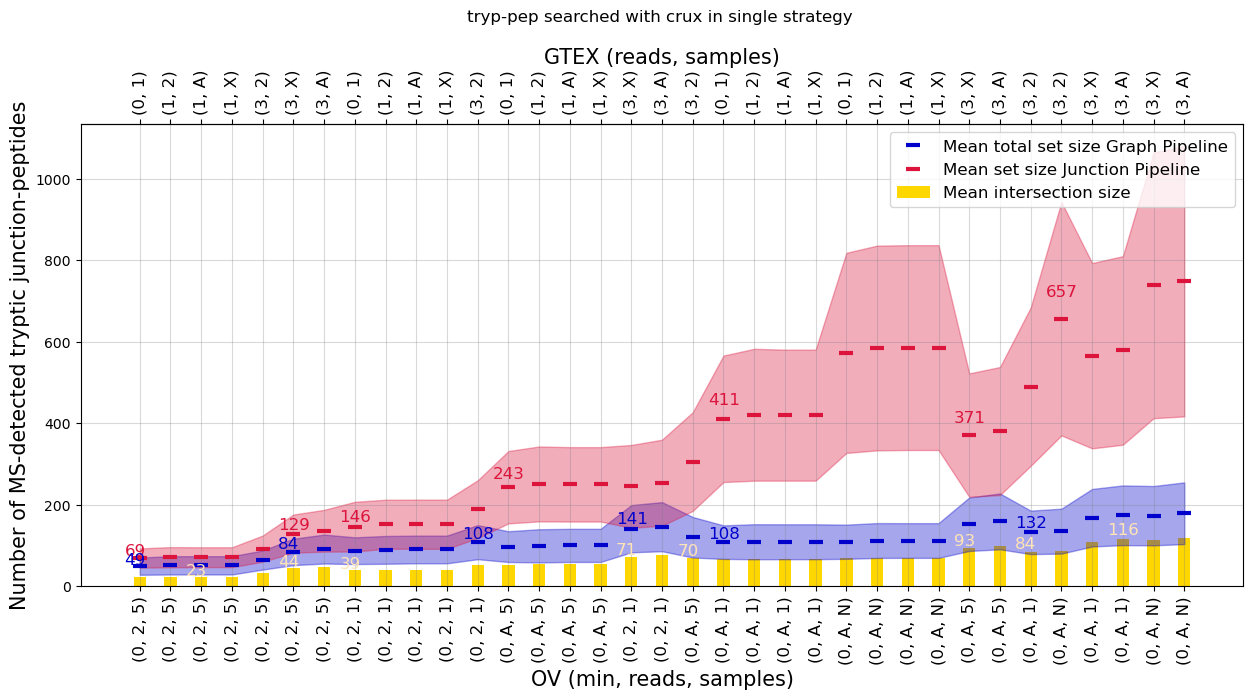

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crux_single.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU              0.0
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU              0.0
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

(54, 21)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_kmer_crux_single.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


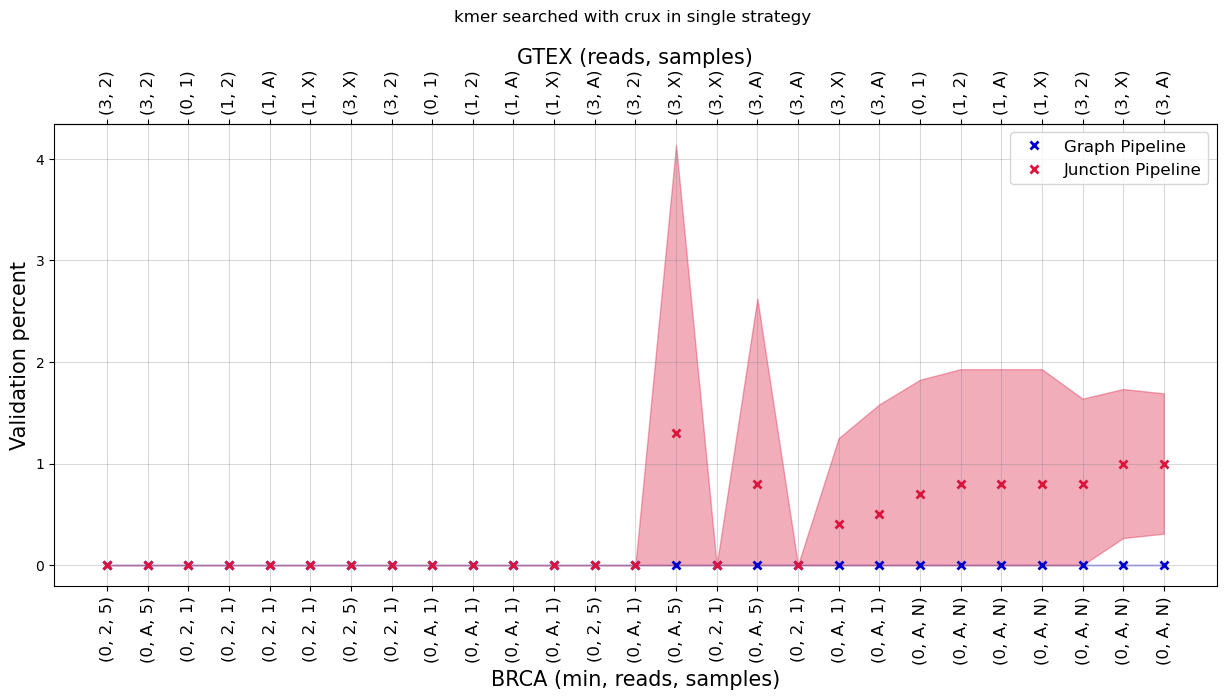

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crux_single.tsv.gz


sample  filter_ pipeline  validation_rate
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA      ETH              0.0
1  TCGA-C8-A12P-01A-11R-A115-07  0211AGA     OHSU              0.0
2  TCGA-C8-A12P-01A-11R-A115-07  0211XGA      ETH              0.0
3  TCGA-C8-A12P-01A-11R-A115-07  0211XGA     OHSU              0.0
4  TCGA-C8-A12P-01A-11R-A115-07  02532GA      ETH              0.0

(54, 21)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_tryp-pep_crux_single.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


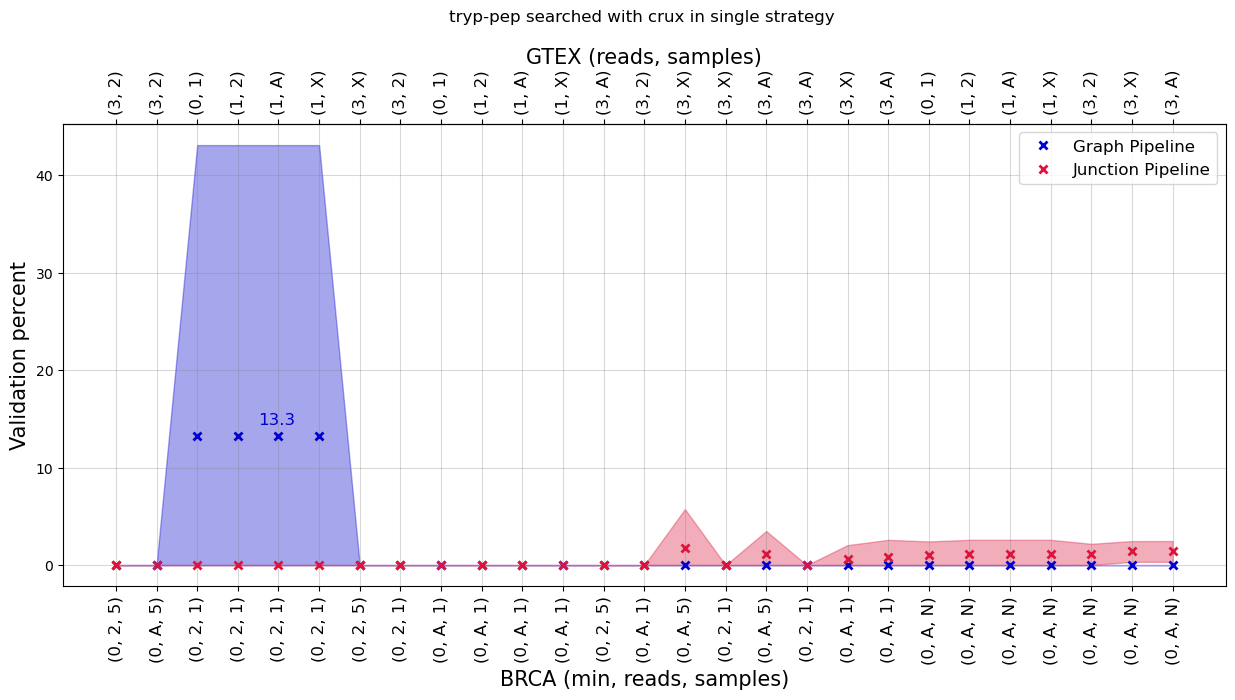

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crux_single.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              0             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              0             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              0             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  0                  0  
1                      0                  0                  0  
2                      0                  0                  0  
3                      0                  0                  0  
4                      0                  0                  0

(27, 32)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_kmer_crux_single.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


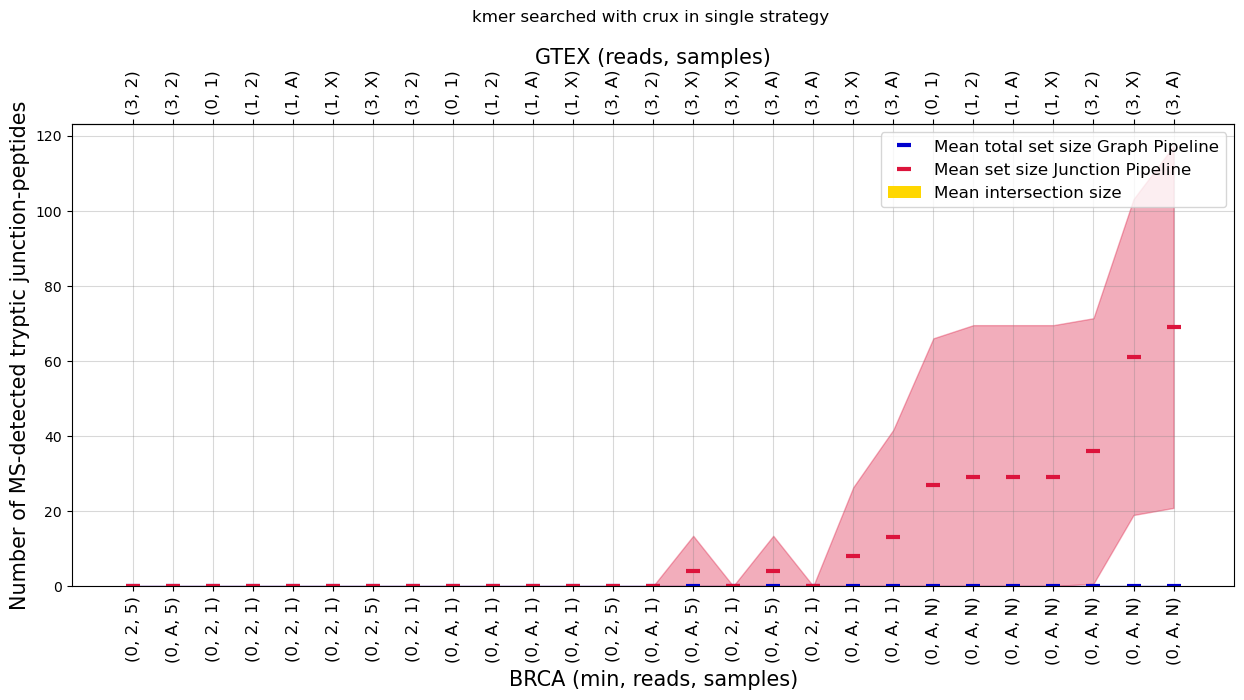

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crux_single.tsv.gz


sample  filter_  pep_size_ohsu  pep_size_eth  \
0  TCGA-C8-A12P-01A-11R-A115-07  0211AGA              0             0   
1  TCGA-C8-A12P-01A-11R-A115-07  0211XGA              0             0   
2  TCGA-C8-A12P-01A-11R-A115-07  02532GA              0             0   
3  TCGA-C8-A12P-01A-11R-A115-07  0A101GA              0             0   
4  TCGA-C8-A12P-01A-11R-A115-07  0A512GA              0             0   

   pep_size_intersection  pep_size_ohsu\eth  pep_size_eth\ohsu  
0                      0                  0                  0  
1                      0                  0                  0  
2                      0                  0                  0  
3                      0                  0                  0  
4                      0                  0                  0

(27, 32)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_tryp-pep_crux_single.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


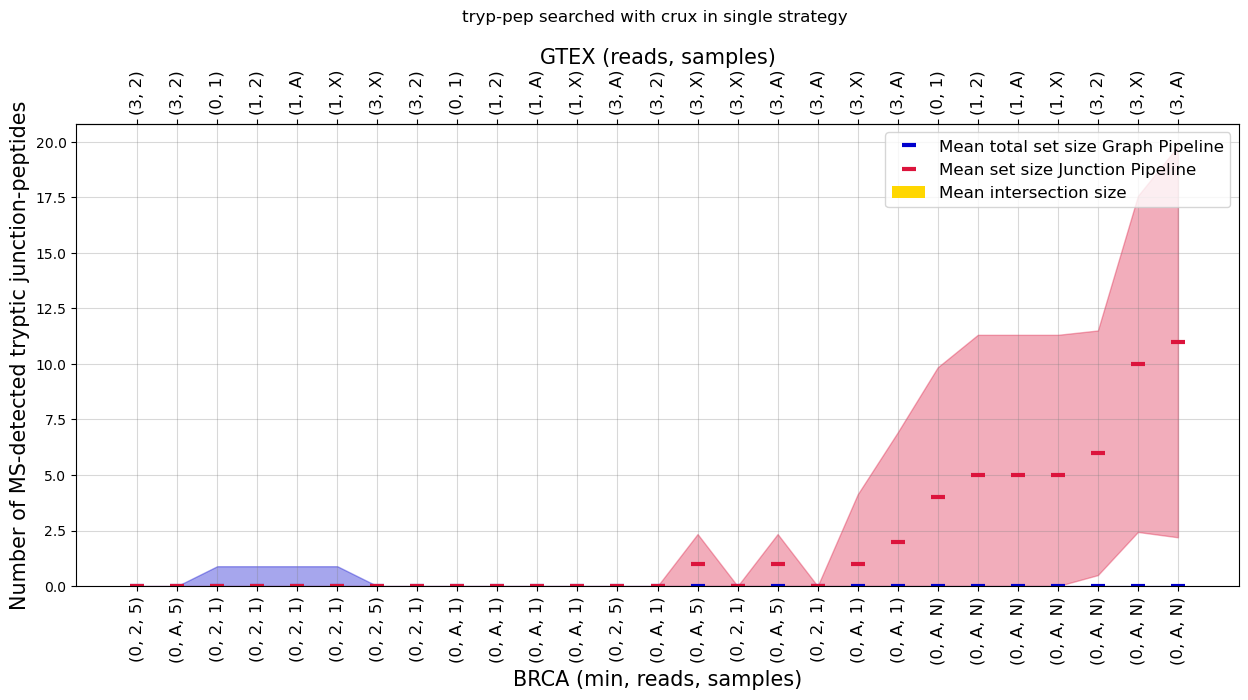

In [7]:
# MAIN 

for MS_FDR in MS_FDR_:
    for MS_strategy in MS_strategy_:
        param_MS.edit_MS( MS_FDR, MS_strategy)
        for sample in ['TCGA-25-1319-01A-01R-1565-13', 'TCGA-AO-A0JM-01A-21R-A056-07']:

            # Intermediate paths filtering
            order_file = os.path.join(sample_plot_dir[sample], f'{sample}_Barplot_sorting.tsv.gz')

            # Intermediate data path MS results
            path_data_pep = os.path.join(save_folder, f'data_peptides{MS_FDR}_{MS_strategy}.tsv.gz')
            path_data_kmers = os.path.join(save_folder, f'data_kmers{MS_FDR}_{MS_strategy}.tsv.gz')
            path_data_peptide_rates = os.path.join(save_folder, f'data_peptides-rates{MS_FDR}_{MS_strategy}.tsv.gz')
            path_data_kmers_rates = os.path.join(save_folder, f'data_kmers-rates{MS_FDR}_{MS_strategy}.tsv.gz')

            # Read data and plot
            group_cols = ['filter_', 'pipeline']
            target_cols = ['validation_rate']
            for suffix, path_data in zip(['kmer', 'tryp-pep'], [path_data_kmers_rates, path_data_peptide_rates]):
                print(f' Reading {path_data}')
                df = pd.read_csv(path_data, sep = '\t')
                display(df.head())
                df = calculate_mean_std(df, group_cols, target_cols, run_type_plot_dir, sample, decimals=1)
                param_MS.edit_pep_type(suffix)
                param_object.edit_marker(marker_type="x", marker_size=6, markeredgewidth=2)

                df_plot = run_sample_plotting_rates(order_file, sample, df, param_MS, param_object)
            
            # Read data and plot
            group_cols = ['filter_']
            target_cols = ['pep_size_ohsu', 'pep_size_eth', 'pep_size_intersection', 
                              'pep_size_ohsu\eth', 'pep_size_eth\ohsu']
            for suffix, path_data in zip(['kmer', 'tryp-pep'], [path_data_kmers, path_data_pep]):

                print(f' Reading {path_data}')
                df = pd.read_csv(path_data, sep = '\t')
                display(df.head())
                df = calculate_mean_std(df, group_cols, target_cols, run_type_plot_dir, sample, decimals=0)
                param_MS.edit_pep_type(suffix)
                param_object.edit_marker(marker_type = "_", marker_size = 10, markeredgewidth=3)
                df_plot = run_sample_plotting_overlap(order_file, sample, df, param_MS, param_object)
